<a href="https://colab.research.google.com/github/francescostreet/ShreckCiuchino2026/blob/main/Notebook%20Corretto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧠 AN2DL [2025-2026]: Time Series Classification Challenge
Thos model aims to develop a **deep learning model** that classifies **multivariate temporal series**.

**Authors:** Andrea Venezia - Francesco Urbano Sereno - Francesco Street

**Date:** November 2025

**Report:**

**Challenge:** [AN2DL: Time Series Classification](https://www.kaggle.com/competitions/an2dl2526c1/overview)

**Github:**

## 1.🌐 **Google Drive Connection**




In [1]:
# @title 🌐 Mount Google Drive
from google.colab import drive
drive.mount("/content/drive")

# Define project directory
current_dir = "/content/drive/MyDrive/Challenge1-Datasets"
%cd $current_dir


print(f"✅ Working directory set to: {current_dir}")

Mounted at /content/drive
/content/drive/MyDrive/Challenge1-Datasets
✅ Working directory set to: /content/drive/MyDrive/Challenge1-Datasets


## 2.⚙️ **ENVIRONMENT SETUP & LIBRARIES IMPORT**

In [2]:
# @title ⚙️ Setup Environment
import os, random, warnings, logging
import numpy as np, torch

SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
os.environ["MPLCONFIGDIR"] = os.getcwd() + "/configs/"
np.random.seed(SEED); random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
warnings.simplefilter("ignore", category=FutureWarning)
logging.getLogger("matplotlib").setLevel(logging.ERROR)
print(f"✅ Environment ready | CUDA available: {torch.cuda.is_available()}")

✅ Environment ready | CUDA available: False


In [3]:
# @title 📦 Import Libraries
import copy, shutil
from itertools import product
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale=1.4)
sns.set_style("white")
plt.rc("font", size=14)
%matplotlib inline

!mkdir -p models logs_dir
!pkill -f tensorboard || echo "No active TensorBoard"
%load_ext tensorboard

^C


In [4]:
# @title 💻 Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ PyTorch {torch.__version__} | Device: {device}")

✅ PyTorch 2.8.0+cu126 | Device: cpu


## 3.⏳ **DATA LOADING**

In [124]:
# @title ⏳ Data Loading
import pandas as pd

# Define dataset directory
current_dir = '/content/drive/MyDrive/Challenge1-Datasets'

# Define file paths
train_path = os.path.join(current_dir, 'pirate_pain_train.csv')
train_labels_path = os.path.join(current_dir, 'pirate_pain_train_labels.csv')
test_path = os.path.join(current_dir, 'pirate_pain_test.csv')

# Load CSV files
X_train = pd.read_csv(train_path)
y_train = pd.read_csv(train_labels_path)
X_test = pd.read_csv(test_path)

# Display dataset info
print(f"✅ Data loaded successfully from {current_dir}")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape:  {X_test.shape}")

✅ Data loaded successfully from /content/drive/MyDrive/Challenge1-Datasets
X_train shape: (105760, 40)
y_train shape: (661, 2)
X_test shape:  (211840, 40)


## 4.🔎 **EXPLORATION AND DATA ANALYSIS**

In [125]:
# @title Preprocessing Training and Test DataFrames

# Define column names
column_names = ['sample_index', 'time', 'pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4', 'n_legs', 'n_hands', 'n_eyes'] + [f'joint_{ind:02d}' for ind in range(31)]

# Read the Training and Test datasets into a DataFrame with specified column names
df = pd.read_csv(train_path, header=0, names=column_names)
df_test = pd.read_csv(test_path, header=0, names=column_names)

# Remove rows with any missing values
df.dropna(axis=0, how='any', inplace=True)

# Print the shape of the DataFrame
print(f"DataFrame shape: {df.shape}")



DataFrame shape: (105760, 40)


In [126]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105760 entries, 0 to 105759
Data columns (total 40 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   sample_index   105760 non-null  int64  
 1   time           105760 non-null  int64  
 2   pain_survey_1  105760 non-null  int64  
 3   pain_survey_2  105760 non-null  int64  
 4   pain_survey_3  105760 non-null  int64  
 5   pain_survey_4  105760 non-null  int64  
 6   n_legs         105760 non-null  object 
 7   n_hands        105760 non-null  object 
 8   n_eyes         105760 non-null  object 
 9   joint_00       105760 non-null  float64
 10  joint_01       105760 non-null  float64
 11  joint_02       105760 non-null  float64
 12  joint_03       105760 non-null  float64
 13  joint_04       105760 non-null  float64
 14  joint_05       105760 non-null  float64
 15  joint_06       105760 non-null  float64
 16  joint_07       105760 non-null  float64
 17  joint_08       105760 non-nul

In [127]:
# @title Inspecting string columns
# Features "n_legs", "n_hands", "n_eyes" are objects, they need to be converted
# into float32, in order to be correctly used by the model.
# This step helps understanding the distinct categories within these columns,
# which helps in deciding how to convert them into a numerical format for modeling.

# Find all the unique string values
for col in ['n_legs', 'n_hands', 'n_eyes']:
    unique_vals = df[col].unique()
    print(f"Unique strings in '{col}': {unique_vals}")

Unique strings in 'n_legs': ['two' 'one+peg_leg']
Unique strings in 'n_hands': ['two' 'one+hook_hand']
Unique strings in 'n_eyes': ['two' 'one+eye_patch']


In [128]:
# @title Mapping

n_cols = ['n_legs', 'n_hands', 'n_eyes']
mapping = {
    'two': 2,
    'one+peg_leg': 1,
    'one+hook_hand': 1,
    'one+eye_patch': 1
}

# Map into float type
for col in n_cols:
    df[col] = df[col].map(mapping).astype(np.float32)
    df_test[col] = df_test[col].map(mapping).astype(np.float32)

# Convert joint features to float
for i in range(31):
  df[f'joint_{i:02d}']= df[f'joint_{i:02d}'].astype(np.float32)
  df_test[f'joint_{i:02d}']= df_test[f'joint_{i:02d}'].astype(np.float32)



In [129]:
# Display updated Training and Test DataFrame information
df.info()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105760 entries, 0 to 105759
Data columns (total 40 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   sample_index   105760 non-null  int64  
 1   time           105760 non-null  int64  
 2   pain_survey_1  105760 non-null  int64  
 3   pain_survey_2  105760 non-null  int64  
 4   pain_survey_3  105760 non-null  int64  
 5   pain_survey_4  105760 non-null  int64  
 6   n_legs         105760 non-null  float32
 7   n_hands        105760 non-null  float32
 8   n_eyes         105760 non-null  float32
 9   joint_00       105760 non-null  float32
 10  joint_01       105760 non-null  float32
 11  joint_02       105760 non-null  float32
 12  joint_03       105760 non-null  float32
 13  joint_04       105760 non-null  float32
 14  joint_05       105760 non-null  float32
 15  joint_06       105760 non-null  float32
 16  joint_07       105760 non-null  float32
 17  joint_08       105760 non-nul

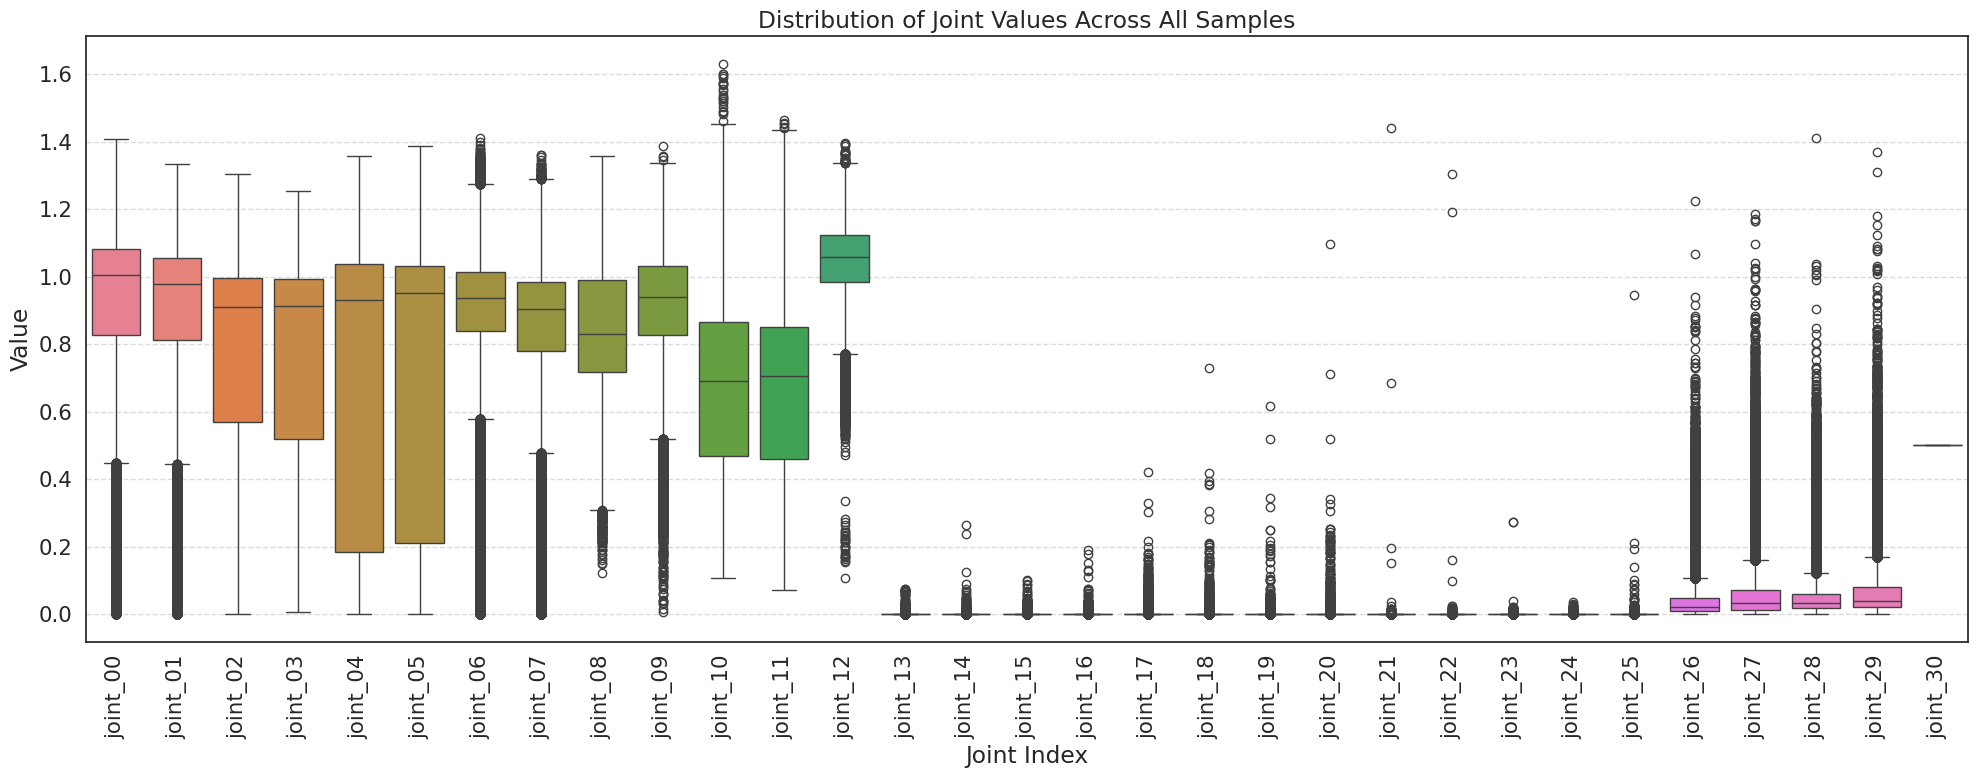

In [131]:
# @title Features Box Plot
import matplotlib.pyplot as plt
import seaborn as sns

# Identify all joint columns
joint_columns = [col for col in df.columns if col.startswith('joint_')]

# Create a box plot for each joint column
plt.figure(figsize=(20, 8)) # Adjust figure size for better readability
sns.boxplot(data=df[joint_columns])
plt.title('Distribution of Joint Values Across All Samples')
plt.xlabel('Joint Index')
plt.ylabel('Value')
plt.xticks(rotation=90) # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## 5.🧮 REMOVING CONSTANT OR NEAR-CONSTANT FEATURES
Some columns in the dataset contain the same value for all (or almost all) samples (joints from 13 to 25 and joint 30),
providing non-informative contribute for model training.  
These features can be removed to reduce dimensionality and improve training stability.  
This can be achieved by computing the variance for each column and dropping columns whose variance is below a small threshold (1e-3).

In [120]:
# @title Removing constant or near-constant features
# As shown from the previous info() plots, the two dataframes are now composed
# by only numerical features. Variance can be computed on the whole dataframes.
# Every feature below a small threshold (1e-3) is being filterd.

# Compute variance for each column
variance = df.var()
variance_test = df_test.var()

# Select columns with variance greater than a small threshold
cols_to_keep = variance[variance > 1e-3].index
cols_to_keep_test = variance[variance > 1e-3].index

# Create new DataFrames containing only variable features
df_temp = df[cols_to_keep]
df_test_temp = df_test[cols_to_keep_test]

df = df_temp
df_test = df_test_temp

# Display summary to confirm the feature reduction
print(f"✅ Kept {len(cols_to_keep)} features (variance > 1e-3)")
df.info()
df_test.info()

✅ Kept 26 features (variance > 1e-3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105760 entries, 0 to 105759
Data columns (total 26 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   sample_index   105760 non-null  int64  
 1   time           105760 non-null  int64  
 2   pain_survey_1  105760 non-null  int64  
 3   pain_survey_2  105760 non-null  int64  
 4   pain_survey_3  105760 non-null  int64  
 5   pain_survey_4  105760 non-null  int64  
 6   n_legs         105760 non-null  float32
 7   n_hands        105760 non-null  float32
 8   n_eyes         105760 non-null  float32
 9   joint_00       105760 non-null  float32
 10  joint_01       105760 non-null  float32
 11  joint_02       105760 non-null  float32
 12  joint_03       105760 non-null  float32
 13  joint_04       105760 non-null  float32
 14  joint_05       105760 non-null  float32
 15  joint_06       105760 non-null  float32
 16  joint_07       105760 non-null  float

## 6.🧩 ADDING LABELS
We attach the target labels to the training set.   
We then remove any remaining rows with missing values to ensure data consistency before modeling.  


In [122]:
# @title Merge label column and clean datasets

# Merge df with y_train (the original labels DataFrame) to add the 'label' column
df = pd.merge(df, y_train, on='sample_index', how='left')

# Remove rows with any missing values
df.dropna(axis=0, how='any', inplace=True)
df_test.dropna(axis=0, how='any', inplace=True)

# Print resulting shapes
print("✅ Final data shapes after merging and cleaning:")
print(f"Training set: {df.shape}")
print(f"Test set:     {df_test.shape}")

# Display the first 10 rows of the DataFrame
print("\n Training Data (first 10 samples):")
display(df.head(10))
print("\n Test Data (first 10 samples):")
display(df_test.head(10))

✅ Final data shapes after merging and cleaning:
Training set: (105760, 28)
Test set:     (211840, 26)

 Training Data (first 10 samples):


,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,n_legs,n_hands,n_eyes,joint_00,...,joint_09,joint_10,joint_11,joint_12,joint_26,joint_27,joint_28,joint_29,label_x,label_y
0,0,0,2,0,2,1,2.0,2.0,2.0,1.094705,...,1.050142,0.529555,0.447370,1.091046,0.017592,0.013508,0.026798,0.027815,no_pain,no_pain
1,0,1,2,2,2,2,2.0,2.0,2.0,1.135183,...,1.060313,0.446810,0.414432,1.045862,0.013352,0.000000,0.013377,0.013716,no_pain,no_pain
2,0,2,2,0,2,2,2.0,2.0,2.0,1.080745,...,1.011410,0.432499,0.431535,1.088221,0.016225,0.008110,0.024097,0.023105,no_pain,no_pain
3,0,3,2,2,2,2,2.0,2.0,2.0,0.938017,...,1.047223,0.478806,0.420665,1.096833,0.011832,0.007450,0.028613,0.024648,no_pain,no_pain
4,0,4,2,2,2,2,2.0,2.0,2.0,1.090185,...,1.044731,0.452906,0.476537,1.103968,0.005360,0.002532,0.033026,0.025328,no_pain,no_pain
5,0,5,2,0,2,1,2.0,2.0,2.0,1.146031,...,1.056162,0.547064,0.464709,1.143319,0.006150,0.006444,0.033101,0.023767,no_pain,no_pain
6,0,6,2,1,2,1,2.0,2.0,2.0,1.025870,...,1.042529,0.445074,0.474467,1.063973,0.006495,0.006421,0.031804,0.019056,no_pain,no_pain
7,0,7,2,2,2,2,2.0,2.0,2.0,1.038597,...,0.996125,0.468641,0.463964,1.145227,0.015998,0.005397,0.035552,0.015732,no_pain,no_pain
8,0,8,2,2,0,1,2.0,2.0,2.0,0.984251,...,0.986229,0.454055,0.478525,1.101066,0.020539,0.008517,0.008635,0.015257,no_pain,no_pain
9,0,9,0,2,2,2,2.0,2.0,2.0,1.054999,...,0.991768,0.506058,0.419849,1.050455,0.007682,0.021383,0.034006,0.028966,no_pain,no_pain



 Test Data (first 10 samples):


,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,n_legs,n_hands,n_eyes,joint_00,...,joint_07,joint_08,joint_09,joint_10,joint_11,joint_12,joint_26,joint_27,joint_28,joint_29
0,0,0,2,2,2,2,2.0,2.0,2.0,0.842535,...,0.950154,1.057105,1.061014,0.327447,0.253370,1.177406,0.019372,0.066324,0.022228,0.013576
1,0,1,2,2,2,2,2.0,2.0,2.0,0.898836,...,0.993922,1.105165,1.015887,0.331900,0.294067,0.985953,0.069747,0.080417,0.023650,0.038793
2,0,2,2,2,2,2,2.0,2.0,2.0,0.957765,...,0.982370,1.142910,1.032120,0.384204,0.272972,1.059171,0.054968,0.058811,0.027023,0.054202
3,0,3,1,2,2,2,2.0,2.0,2.0,0.832596,...,0.944723,1.057460,1.013968,0.381349,0.283902,1.132100,0.048695,0.047128,0.016151,0.024983
4,0,4,2,2,2,0,2.0,2.0,2.0,0.805972,...,0.948609,1.008785,0.974159,0.380332,0.311384,0.980731,0.019762,0.031116,0.015618,0.017931
5,0,5,2,2,0,2,2.0,2.0,2.0,0.805308,...,1.025050,1.050914,1.023095,0.310682,0.209324,0.936655,0.037433,0.034157,0.013880,0.033762
6,0,6,2,2,0,2,2.0,2.0,2.0,0.878559,...,0.926120,1.054816,1.030822,0.309517,0.300793,1.135787,0.076399,0.025877,0.049272,0.037960
7,0,7,2,2,2,2,2.0,2.0,2.0,0.847666,...,0.944574,1.041811,0.956960,0.376977,0.279399,1.022974,0.041566,0.055916,0.024414,0.026338
8,0,8,2,2,2,1,2.0,2.0,2.0,0.913557,...,1.022430,1.044301,1.014973,0.351867,0.279328,1.138381,0.040049,0.047536,0.018454,0.010675
9,0,9,2,2,2,0,2.0,2.0,2.0,0.880579,...,0.953042,1.080148,1.009135,0.312861,0.364807,1.049919,0.022977,0.096785,0.035494,0.023898


In [71]:
# Generate descriptive statistics for numerical columns in the DataFrame
df.describe()

,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,joint_00,joint_01,joint_02,joint_03,...,joint_07,joint_08,joint_09,joint_10,joint_11,joint_12,joint_26,joint_27,joint_28,joint_29
count,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,...,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000
mean,330.000000,79.500000,1.633746,1.654851,1.653640,1.663134,0.943095,0.916955,0.779296,0.767921,...,0.837427,0.849700,0.909554,0.694840,0.691105,1.047288,0.041905,0.058244,0.049886,0.062273
std,190.814948,46.187338,0.682423,0.669639,0.666649,0.661994,0.202049,0.197606,0.295603,0.300786,...,0.237901,0.180488,0.180319,0.257571,0.262644,0.110833,0.060292,0.079820,0.060773,0.072597
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001015,0.005403,...,0.000000,0.122095,0.004671,0.107917,0.072233,0.107136,0.000203,0.000000,0.000000,0.000000
25%,165.000000,39.750000,2.000000,2.000000,2.000000,2.000000,0.828277,0.811445,0.568850,0.520020,...,0.781375,0.717725,0.825898,0.469688,0.460407,0.983152,0.009885,0.012652,0.016290,0.019638
50%,330.000000,79.500000,2.000000,2.000000,2.000000,2.000000,1.005126,0.979468,0.909549,0.914834,...,0.904914,0.831221,0.940954,0.690806,0.705150,1.057917,0.021898,0.031739,0.031843,0.039041
75%,495.000000,119.250000,2.000000,2.000000,2.000000,2.000000,1.081039,1.056611,0.995187,0.994324,...,0.984410,0.991104,1.030941,0.866482,0.851772,1.124471,0.048579,0.071051,0.058741,0.079518
max,660.000000,159.000000,2.000000,2.000000,2.000000,2.000000,1.407968,1.334613,1.306046,1.254729,...,1.361969,1.357288,1.388105,1.631494,1.464157,1.396754,1.223617,1.187419,1.412037,1.370765


Extracted 4 pain survey columns.
First 5 rows of the new pain_survey_df:
Counts of 0, 1, and 2 for each pain_survey column:
pain_survey_1: {0: 12352, 1: 14031, 2: 79377}
pain_survey_2: {0: 11760, 1: 12983, 2: 81017}
pain_survey_3: {0: 11529, 1: 13573, 2: 80658}
pain_survey_4: {0: 11361, 1: 12905, 2: 81494}
Total aggregated counts of 0, 1, and 2 across all pain_survey columns:
{0: 47002, 1: 53492, 2: 322546}


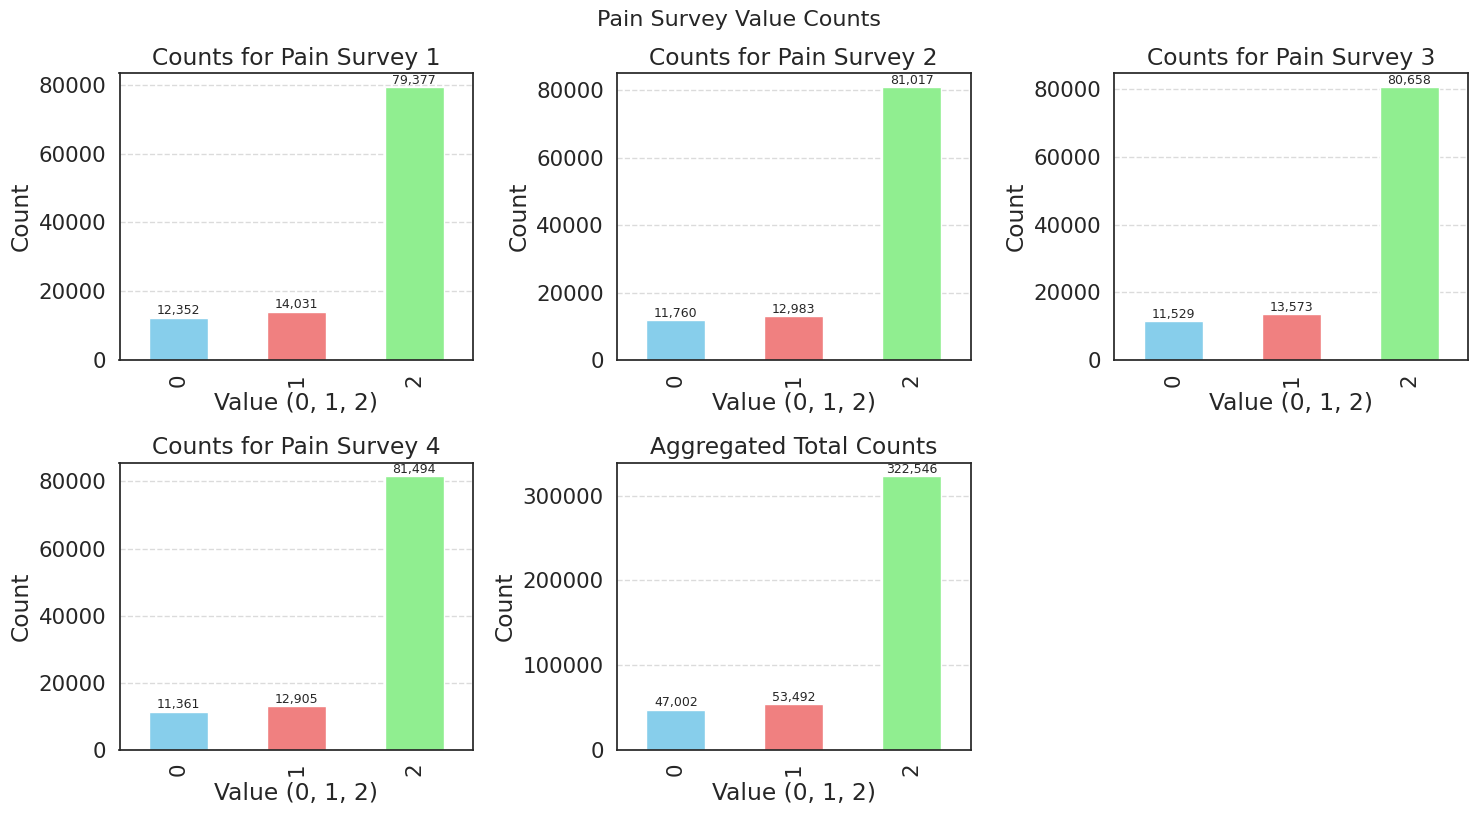

In [72]:
# @title
pain_survey_columns = [col for col in df.columns if col.startswith('pain_survey')]
pain_survey_df = df[pain_survey_columns]

print(f"Extracted {len(pain_survey_columns)} pain survey columns.")
print("First 5 rows of the new pain_survey_df:")
pain_survey_df.head()

pain_counts = {}
for col in pain_survey_columns:
    counts = pain_survey_df[col].value_counts().reindex([0, 1, 2], fill_value=0)
    pain_counts[col] = counts.to_dict()

print("Counts of 0, 1, and 2 for each pain_survey column:")
for col, counts in pain_counts.items():
    print(f"{col}: {counts}")

total_pain_counts = {0: 0, 1: 0, 2: 0}
for col, counts in pain_counts.items():
    for value, count in counts.items():
        total_pain_counts[value] += count

print("Total aggregated counts of 0, 1, and 2 across all pain_survey columns:")
print(total_pain_counts)

num_pain_surveys = len(pain_survey_columns)
num_plots = num_pain_surveys + 1 # +1 for the aggregated total

# Determine grid size for subplots dynamically
# For 5 plots, a 2x3 grid works well, leaving one empty spot
if num_plots <= 3:
    ncols = num_plots
    nrows = 1
elif num_plots <= 6:
    ncols = 3
    nrows = (num_plots + ncols - 1) // ncols
else:
    ncols = 4
    nrows = (num_plots + ncols - 1) // ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 4 * nrows))
axes = axes.flatten() # Flatten the array of axes for easy iteration

# Plot individual pain_survey column counts
for i, col in enumerate(pain_survey_columns):
    counts_series = pd.Series(pain_counts[col])
    counts_series.plot(kind='bar', ax=axes[i], color=['skyblue', 'lightcoral', 'lightgreen'])
    axes[i].set_title(f'Counts for {col.replace("_", " ").title()}')
    axes[i].set_xlabel('Value (0, 1, 2)')
    axes[i].set_ylabel('Count')
    axes[i].ticklabel_format(style='plain', axis='y') # Disable scientific notation
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)
    for p in axes[i].patches:
        axes[i].annotate(f'{int(p.get_height()):,}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize=9)

# Plot aggregated total counts
total_counts_series = pd.Series(total_pain_counts)
total_counts_series.plot(kind='bar', ax=axes[num_pain_surveys], color=['skyblue', 'lightcoral', 'lightgreen'])
axes[num_pain_surveys].set_title('Aggregated Total Counts')
axes[num_pain_surveys].set_xlabel('Value (0, 1, 2)')
axes[num_pain_surveys].set_ylabel('Count')
axes[num_pain_surveys].ticklabel_format(style='plain', axis='y') # Disable scientific notation
axes[num_pain_surveys].grid(axis='y', linestyle='--', alpha=0.7)
for p in axes[num_pain_surveys].patches:
    axes[num_pain_surveys].annotate(f'{int(p.get_height()):,}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize=9)

# Hide any unused subplots
for j in range(num_plots, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle('Pain Survey Value Counts', y=1.02, fontsize=16)
plt.show()

**FARE TUTTA L'ANALISI E MANIPOLAZIONE DEL DATASET**

In [ ]:
unique_pirates = df['sample_index'].unique()
n_pirates = len(unique_pirates)
print(f"Total number of pirates in the dataset: {n_pirates}")

random.seed(SEED) # Ensure reproducibility of shuffling
random.shuffle(unique_pirates)

# Define the number of users for validation and test sets
N_VAL_USERS = 135 # You can change this number

# Calculate the number of users for the training set
n_train_users = len(unique_pirates) - N_VAL_USERS

# Split the shuffled user IDs into training and validation
train_users = unique_pirates[:n_train_users]
val_users = unique_pirates[n_train_users:n_train_users + N_VAL_USERS]

# Split the dataset into training, validation, and test sets based on user IDs
df_train = df[df['sample_index'].isin(train_users)]
df_val = df[df['sample_index'].isin(val_users)]

# Print the shapes of the training, validation, and test sets
print(f'Training set shape: {df_train.shape}')
print(f'Validation set shape: {df_val.shape}')

Total number of pirates in the dataset: 661
Training set shape: (84160, 27)
Validation set shape: (21600, 27)


In [ ]:
# Define the columns to be normalised
scale_columns = ['pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4', 'n_legs', 'n_hands', 'n_eyes'] + [f'joint_{ind:02d}' for ind in range(13)] + ['joint_26', 'joint_27', 'joint_28', 'joint_29',]

# Calculate the minimum and maximum values from the training data only
mins = df_train[scale_columns].min()
maxs = df_train[scale_columns].max()

# Apply normalisation to the specified columns in all datasets
for column in scale_columns:
    # Normalise the training set and ensure float32
    df_train[column] = ((df_train[column] - mins[column]) / (maxs[column] - mins[column])).astype(np.float32)

    # Normalise the validation set and ensure float32
    df_val[column] = ((df_val[column] - mins[column]) / (maxs[column] - mins[column])).astype(np.float32)

    # Normalise the test set and ensure float32
    df_test[column] = ((df_test[column] - mins[column]) / (maxs[column] - mins[column])).astype(np.float32)

In [ ]:
# === Estrarre feature statiche per sample_index (una riga per soggetto) ===
static_cols = ['n_legs', 'n_hands', 'n_eyes']

# Assicurati che df_train, df_val, df_test esistano già (li hai creati poco sopra)
static_train_df = df_train.groupby('sample_index')[static_cols].first().astype(np.float32)
static_val_df   = df_val.groupby('sample_index')[static_cols].first().astype(np.float32)
static_test_df  = df_test.groupby('sample_index')[static_cols].first().astype(np.float32)

# Controllo rapido (opzionale)
print("Static train shape (subjects):", static_train_df.shape)
print("Static val shape (subjects):", static_val_df.shape)
print("Static test shape (subjects):", static_test_df.shape)


Static train shape (subjects): (526, 3)
Static val shape (subjects): (135, 3)
Static test shape (subjects): (1324, 3)


In [ ]:
# Display the first five rows of the training DataFrame
print(df_train.shape)
df_train.head()

(84160, 27)


,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,n_legs,n_hands,n_eyes,joint_00,...,joint_08,joint_09,joint_10,joint_11,joint_12,joint_26,joint_27,joint_28,joint_29,label
0,0,0,1.0,0.0,1.0,0.5,1.0,1.0,1.0,0.777507,...,0.478382,0.755707,0.276742,0.269510,0.762947,0.014211,0.011376,0.018978,0.020291,no_pain
1,0,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.806256,...,0.486231,0.763060,0.222432,0.245846,0.727910,0.010745,0.000000,0.009473,0.010006,no_pain
2,0,2,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.767592,...,0.441994,0.727711,0.213039,0.258133,0.760757,0.013093,0.006830,0.017065,0.016856,no_pain
3,0,3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.666220,...,0.469554,0.753597,0.243433,0.250324,0.767434,0.009502,0.006274,0.020264,0.017981,no_pain
4,0,4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.774297,...,0.477740,0.751796,0.226434,0.290464,0.772967,0.004212,0.002132,0.023389,0.018477,no_pain


In [ ]:
# Display the first five rows of the test DataFrame
print(df_test.shape)
df_test.head()

(211840, 26)


,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,n_legs,n_hands,n_eyes,joint_00,...,joint_07,joint_08,joint_09,joint_10,joint_11,joint_12,joint_26,joint_27,joint_28,joint_29
0,0,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.598405,...,0.697633,0.756975,0.763566,0.144088,0.130134,0.829913,0.015666,0.055856,0.015742,0.009904
1,0,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.638393,...,0.729769,0.795884,0.730947,0.147011,0.159372,0.681456,0.056841,0.067724,0.016749,0.028300
2,0,2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.680247,...,0.721287,0.826442,0.742680,0.181341,0.144217,0.738230,0.044761,0.049528,0.019138,0.039542
3,0,3,0.5,1.0,1.0,1.0,1.0,1.0,1.0,0.591346,...,0.693645,0.757262,0.729559,0.179467,0.152069,0.794781,0.039633,0.039690,0.011438,0.018225
4,0,4,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.572436,...,0.696499,0.717856,0.700784,0.178800,0.171814,0.677406,0.015984,0.026205,0.011061,0.013081


In [ ]:
# Define a mapping of activity names to integer labels
label_mapping = {
    'no_pain': 0,
    'low_pain': 1,
    'high_pain': 2,
}

# Map activity names to integers in the training set
df_train['label'] = df_train['label'].map(label_mapping)

# Map activity names to integers in the validation set
df_val['label'] = df_val['label'].map(label_mapping)

**MODEL DEFINITION AND CO FROM HERE ON**

In [ ]:
WINDOW_SIZE= 60 # I wouldn't exceed 180 since each "activity" is composed by 180 measures, by
STRIDE= 20 # random first guess

In [ ]:
# Define a function to build sequences from the dataset
def build_sequences(df, window=WINDOW_SIZE, stride=STRIDE, return_labels=True, feature_columns_to_extract=None):
    # Sanity check to ensure the window is divisible by the stride
    assert window % stride == 0

    dataset = []
    labels = []
    sequence_ids = [] # New list to store sample_index for each sequence

    # Always use 'sample_index' as the ID column as per user request
    id_column = 'sample_index'

    # Always use 'label' as the label column as per user request
    label_column = 'label'

    # Use provided feature_columns_to_extract or default to all 'joint_' columns if not specified
    if feature_columns_to_extract is None:
        feature_columns_to_extract = [col for col in df.columns if col.startswith('joint_')]

    if not feature_columns_to_extract:
        raise ValueError("No feature columns provided or found for sequence building.")

    for current_id in df[id_column].unique():
        # Extract sensor data for the current ID using the specified feature columns
        temp_data = df[df[id_column] == current_id][feature_columns_to_extract].values

        # Handle cases where a user might have no data points (empty temp_data)
        if len(temp_data) == 0:
            continue

        current_label = None
        if return_labels:
            if label_column in df.columns:
                current_label = df[df[id_column] == current_id][label_column].values[0]
            else:
                # If labels are expected but the column is missing, raise an error
                raise KeyError(f"Label column '{label_column}' not found in DataFrame for ID {current_id} when labels are expected (return_labels=True).")
        # If return_labels is False, current_label remains None or is not used for appending

        # Calculate padding length to ensure full windows
        padding_len = window - (len(temp_data) % window)
        if padding_len == window: # If len(temp_data) is a multiple of window, no padding needed
            padding_len = 0

        # Create zero padding and concatenate with the data
        if padding_len > 0:
            padding = np.zeros((padding_len, temp_data.shape[1]), dtype='float32')
            temp_data = np.concatenate((temp_data, padding))

        # Build feature windows and associate them with labels
        idx = 0
        while idx + window <= len(temp_data):
            dataset.append(temp_data[idx:idx + window])
            if return_labels:
                labels.append(current_label) # Append the actual label
            else:
                labels.append(-1) # Append a placeholder if not returning labels, for shape consistency in list before converting to numpy
            sequence_ids.append(current_id) # Append the current_id for each sequence
            idx += stride

    dataset_np = np.array(dataset)
    labels_np = np.array(labels, dtype=np.int64) if return_labels else np.empty(0, dtype=np.int64)
    sequence_ids_np = np.array(sequence_ids)

    return dataset_np, labels_np, sequence_ids_np

In [ ]:
# Get the list of actual joint columns present in the preprocessed dataframes
actual_joint_columns_global = [col for col in df_train.columns if col.startswith('joint_')]

# Generate sequences and labels for the training set
X_train, y_train, seq_ids_train = build_sequences(df_train, WINDOW_SIZE, STRIDE, feature_columns_to_extract=actual_joint_columns_global)

# Generate sequences and labels for the validation set
X_val, y_val, seq_ids_val     = build_sequences(df_val, WINDOW_SIZE, STRIDE, feature_columns_to_extract=actual_joint_columns_global)

# Generate sequences for the test set (without labels)
# df_test does not contain the 'label' column, so we set return_labels=False
X_test, _, seq_ids_test       = build_sequences(df_test, WINDOW_SIZE, STRIDE, return_labels=False, feature_columns_to_extract=actual_joint_columns_global)

# Print the shapes of the generated datasets and their labels
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"seq_ids_test shape: {seq_ids_test.shape}")

X_train shape: (3682, 60, 17), y_train shape: (3682,)
X_val shape: (945, 60, 17), y_val shape: (945,)
X_test shape: (9268, 60, 17)
seq_ids_test shape: (9268,)


In [ ]:
def build_static_array_from_seq_ids(sequence_ids, static_df):
    """
    sequence_ids: array/list of sample_index for each window (in same order as X)
    static_df: DataFrame indexed by sample_index with columns static_cols
    Returns: numpy array shape (n_windows, n_static_features)
    """
    # Some seq ids might not be sorted; use .loc to fetch rows by index
    static_list = [ static_df.loc[idx].values for idx in sequence_ids ]
    return np.vstack(static_list).astype(np.float32)

# Create static arrays aligned with each window
X_train_static = build_static_array_from_seq_ids(seq_ids_train, static_train_df)
X_val_static   = build_static_array_from_seq_ids(seq_ids_val, static_val_df)
X_test_static  = build_static_array_from_seq_ids(seq_ids_test, static_test_df)

print("X_train_static shape:", X_train_static.shape)
print("X_val_static shape:", X_val_static.shape)
print("X_test_static shape:", X_test_static.shape)


X_train_static shape: (3682, 3)
X_val_static shape: (945, 3)
X_test_static shape: (9268, 3)


In [ ]:
# Define the input shape based on the training data
input_shape = X_train.shape[1:]

# Define the number of classes based on the categorical labels
num_classes = len(np.unique(y_train))

In [ ]:
# Convert to tensors and create datasets with sequence + static + label
train_ds = TensorDataset(
    torch.from_numpy(X_train).float(),
    torch.from_numpy(X_train_static).float(),
    torch.from_numpy(y_train).long()
)
val_ds = TensorDataset(
    torch.from_numpy(X_val).float(),
    torch.from_numpy(X_val_static).float(),
    torch.from_numpy(y_val).long()
)
# test dataset (no label)
test_ds = TensorDataset(
    torch.from_numpy(X_test).float(),
    torch.from_numpy(X_test_static).float()
)


In [ ]:
# Define the batch size, which is the number of samples in each batch
BATCH_SIZE = 32 #in this course don't exceed this, isn't useful

In [ ]:
def make_loader(ds, batch_size, shuffle, drop_last):
    # Determine optimal number of worker processes for data loading
    cpu_cores = os.cpu_count() or 2
    num_workers = max(2, min(4, cpu_cores))

    # Create DataLoader with performance optimizations
    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True,  # Faster GPU transfer
        pin_memory_device="cuda" if torch.cuda.is_available() else "",
        prefetch_factor=4,  # Load 4 batches ahead
    )

In [ ]:
# Create data loaders with different settings for each phase
train_loader = make_loader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader   = make_loader(val_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

In [ ]:
# Get one batch from the training data loader
for xb, x_static_batch, yb in train_loader:
    print("Features batch shape:", xb.shape)
    print("Static features batch shape:", x_static_batch.shape)
    print("Labels batch shape:", yb.shape)
    break # Stop after getting one batch

Features batch shape: torch.Size([32, 60, 17])
Static features batch shape: torch.Size([32, 3])
Labels batch shape: torch.Size([32])


🛠️ Model Building

In [ ]:
# @title
def recurrent_summary(model, input_size, static_input_size=0):
    """
    Custom summary function that emulates torchinfo's output while correctly
    counting parameters for RNN/GRU/LSTM layers.

    This function is designed for models whose direct children are
    nn.Linear, nn.RNN, nn.GRU, or nn.LSTM layers.

    Args:
        model (nn.Module): The model to analyze.
        input_size (tuple): Shape of the input tensor (e.g., (seq_len, features)).
        static_input_size (int): Number of static features, if any. Defaults to 0.
    """

    # Dictionary to store output shapes captured by forward hooks
    output_shapes = {}
    # List to track hook handles for later removal
    hooks = []

    def get_hook(name):
        """Factory function to create a forward hook for a specific module."""
        def hook(module, input, output):
            # Handle RNN layer outputs (returns a tuple)
            if isinstance(output, tuple):
                # output[0]: all hidden states with shape (batch, seq_len, hidden*directions)
                shape1 = list(output[0].shape)
                shape1[0] = -1  # Replace batch dimension with -1

                # output[1]: final hidden state h_n (or tuple (h_n, c_n) for LSTM)
                if isinstance(output[1], tuple):  # LSTM case: (h_n, c_n)
                    shape2 = list(output[1][0].shape)  # Extract h_n only
                else:  # RNN/GRU case: h_n only
                    shape2 = list(output[1].shape)

                # Replace batch dimension (middle position) with -1
                shape2[1] = -1

                output_shapes[name] = f"[{shape1}, {shape2}]"

            # Handle standard layer outputs (e.g., Linear)
            else:
                shape = list(output.shape)
                shape[0] = -1  # Replace batch dimension with -1
                output_shapes[name] = f"{shape}"
        return hook

    # 1. Determine the device where model parameters reside
    try:
        device = next(model.parameters()).device
    except StopIteration:
        device = torch.device("cpu")  # Fallback for models without parameters

    # 2. Create dummy input tensors with batch_size=1
    dummy_input = torch.randn(1, *input_size).to(device)
    dummy_static_input = None
    if static_input_size > 0:
        dummy_static_input = torch.randn(1, static_input_size).to(device)

    # 3. Register forward hooks on target layers
    # Iterate through direct children of the model (e.g., self.rnn, self.classifier)
    for name, module in model.named_children():
        if isinstance(module, (nn.Linear, nn.RNN, nn.GRU, nn.LSTM)):
            # Register the hook and store its handle for cleanup
            hook_handle = module.register_forward_hook(get_hook(name))
            hooks.append(hook_handle)

    # 4. Execute a dummy forward pass in evaluation mode
    model.eval()
    with torch.no_grad():
        try:
            if dummy_static_input is not None:
                model(dummy_input, dummy_static_input)
            else:
                model(dummy_input) # If no static input, call with only dynamic input
        except Exception as e:
            print(f"Error during dummy forward pass in recurrent_summary: {e}")
            # Clean up hooks even if an error occurs
            for h in hooks:
                h.remove()
            return

    # 5. Remove all registered hooks
    for h in hooks:
        h.remove()

    # --- 6. Print the summary table ---

    print("-" * 79)
    # Column headers
    print(f"{'Layer (type)':<25} {'Output Shape':<28} {'Param #':<18}")
    print("=" * 79)

    total_params = 0
    total_trainable_params = 0

    # Iterate through modules again to collect and display parameter information
    for name, module in model.named_children():
        if name in output_shapes:
            # Count total and trainable parameters for this module
            module_params = sum(p.numel() for p in module.parameters())
            trainable_params = sum(p.numel() for p in module.parameters() if p.requires_grad)

            total_params += module_params
            total_trainable_params += trainable_params

            # Format strings for display
            layer_name = f"{name} ({type(module).__name__})"
            output_shape_str = str(output_shapes[name])
            params_str = f"{trainable_params:,}"

            print(f"{layer_name:<25} {output_shape_str:<28} {params_str:<15}")

    print("=" * 79)
    print(f"Total params: {total_params:,}")
    print(f"Trainable params: {total_trainable_params:,}")
    print(f"Non-trainable params: {total_params - total_trainable_params:,}")
    print("-" * 79)

In [ ]:
class RecurrentClassifier(nn.Module):
    """
    Generic RNN classifier (RNN, LSTM, GRU).
    Uses the last hidden state for classification.
    """
    def __init__(
            self,
            input_size,
            hidden_size,
            num_layers,
            num_classes,
            rnn_type='GRU',
            bidirectional=False,
            dropout_rate=0.2,
            static_size=0
            ):
        super().__init__()

        self.rnn_type = rnn_type
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional
        self.static_size = static_size


        # Map string name to PyTorch RNN class
        rnn_map = {
            'RNN': nn.RNN,
            'LSTM': nn.LSTM,
            'GRU': nn.GRU
        }

        if rnn_type not in rnn_map:
            raise ValueError("rnn_type must be 'RNN', 'LSTM', or 'GRU'")

        rnn_module = rnn_map[rnn_type]

        # Dropout is only applied between layers (if num_layers > 1)
        dropout_val = dropout_rate if num_layers > 1 else 0

        # Create the recurrent layer
        self.rnn = rnn_module(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout_val
        )

        # Calculate input size for the hidden_to_classify (after RNN, before potential reduction)
        if self.bidirectional:
            classifier_input_size_from_rnn = hidden_size * 2 # Concat fwd + bwd
        else:
            classifier_input_size_from_rnn = hidden_size


        # Calculate input size for the final classifier, incorporating static features
        final_classifier_input_size = classifier_input_size_from_rnn + self.static_size

        # Final classification layer as a small FFN with Leaky ReLU
        # Using final_classifier_input_size as a hidden layer for simplicity
        self.classifier = nn.Sequential(
            nn.Linear(final_classifier_input_size, final_classifier_input_size), # Hidden layer
            nn.LeakyReLU(), # Activation for hidden layer
            nn.Linear(final_classifier_input_size, num_classes) # Output layer
        )


    def forward(self, x, x_static=None):
        """
        x shape: (batch_size, seq_length, input_size)
        x_static shape: (batch_size, static_size) (optional)
        """

        # rnn_out shape: (batch_size, seq_len, hidden_size * num_directions)
        rnn_out, hidden = self.rnn(x)

        # LSTM returns (h_n, c_n), we only need h_n
        if self.rnn_type == 'LSTM':
            hidden = hidden[0]

        # hidden shape: (num_layers * num_directions, batch_size, hidden_size)

        if self.bidirectional:
            # Reshape to (num_layers, 2, batch_size, hidden_size)
            hidden = hidden.view(self.num_layers, 2, -1, self.hidden_size)

            # Concat last fwd (hidden[-1, 0, :, :]) and bwd (hidden[-1, 1, :, :])
            # Final shape: (batch_size, hidden_size * 2)
            hidden_to_classify = torch.cat([hidden[-1, 0, :, :], hidden[-1, 1, :, :]], dim=1) # take the last layer and feed it into the classifier
        else:
            # Take the last layer's hidden state
            # Final shape: (batch_size, hidden_size)
            hidden_to_classify = hidden[-1]

        if x_static is not None:
            # ensure same dtype/device
            x_static = x_static.to(hidden_to_classify.dtype)
            x_static = x_static.to(hidden_to_classify.device)
            hidden_to_classify = torch.cat([hidden_to_classify, x_static], dim=1)

        # Get logits from the sequential classifier
        logits = self.classifier(hidden_to_classify)
        return logits

**NETWORK AND TRAINING HYPERPARAMS**

In [ ]:
LEARNING_RATE = 1e-3
EPOCHS = 500
PATIENCE = 50

HIDDEN_LAYERS = 2
HIDDEN_SIZE = 64

DROPOUT_RATE = 0.3
L1_LAMBDA = 0
L2_LAMBDA = 0

LABEL_SMOOTHING= 0

# Calculate class weights for the imbalanced dataset
# Ensure y_train (numpy array) contains integer labels
class_labels = np.unique(y_train) # Use the global y_train (numpy array) that has integer labels
class_weights_np = compute_class_weight(
    class_weight='balanced',
    classes=class_labels,
    y=y_train
)
class_weights_tensor = torch.tensor(class_weights_np, dtype=torch.float32).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights_tensor, label_smoothing=LABEL_SMOOTHING)

In [ ]:
# Initialize best model tracking variables
best_model = None
best_performance = float('-inf')

In [ ]:
# @title
def train_one_epoch(model, train_loader, criterion, optimizer, scaler, device, l1_lambda=L1_LAMBDA, l2_lambda=L2_LAMBDA):
    """
    Perform one complete training epoch through the entire training dataset.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): Lambda for L1 regularization
        l2_lambda (float): Lambda for L2 regularization

    Returns:
        tuple: (average_loss, f1 score) - Training loss and f1 score for this epoch
    """
    model.train()  # Set model to training mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Iterate through training batches
    for batch_idx, (inputs, static_inputs, targets) in enumerate(train_loader):
        # Move data to device (GPU/CPU)
        inputs, static_inputs, targets = inputs.to(device), static_inputs.to(device), targets.to(device)

        # Clear gradients from previous step
        optimizer.zero_grad(set_to_none=True)

        # Forward pass with mixed precision (if CUDA available)
        with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            logits = model(inputs, static_inputs)
            loss = criterion(logits, targets)

            # Add L1 and L2 regularization
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            l2_norm = sum(p.pow(2).sum() for p in model.parameters())
            loss = loss + l1_lambda * l1_norm + l2_lambda * l2_norm


        # Backward pass with gradient scaling
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Accumulate metrics
        running_loss += loss.item() * inputs.size(0)
        predictions = logits.argmax(dim=1)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_f1 = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_f1

In [ ]:
# @title
def validate_one_epoch(model, val_loader, criterion, device):
    """
    Perform one complete validation epoch through the entire validation dataset.

    Args:
        model (nn.Module): The neural network model to evaluate (must be in eval mode)
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        criterion (nn.Module): Loss function used to calculate validation loss
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)

    Returns:
        tuple: (average_loss, accuracy) - Validation loss and accuracy for this epoch

    Note:
        This function automatically sets the model to evaluation mode and disables
        gradient computation for efficiency during validation.
    """
    model.eval()  # Set model to evaluation mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Disable gradient computation for validation
    with torch.no_grad():
        for inputs, static_inputs, targets in val_loader:
            # Move data to device
            inputs, static_inputs, targets = inputs.to(device), static_inputs.to(device), targets.to(device)

            # Forward pass with mixed precision (if CUDA available)
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                logits = model(inputs, static_inputs)
                loss = criterion(logits, targets)

            # Accumulate metrics
            running_loss += loss.item() * inputs.size(0)
            predictions = logits.argmax(dim=1)
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_accuracy = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_accuracy

In [ ]:
# @title
def log_metrics_to_tensorboard(writer, epoch, train_loss, train_f1, val_loss, val_f1, model):
    """
    Log training metrics and model parameters to TensorBoard for visualization.

    Args:
        writer (SummaryWriter): TensorBoard SummaryWriter object for logging
        epoch (int): Current epoch number (used as x-axis in TensorBoard plots)
        train_loss (float): Training loss for this epoch
        train_f1 (float): Training f1 score for this epoch
        val_loss (float): Validation loss for this epoch
        val_f1 (float): Validation f1 score for this epoch
        model (nn.Module): The neural network model (for logging weights/gradients)

    Note:
        This function logs scalar metrics (loss/f1 score) and histograms of model
        parameters and gradients, which helps monitor training progress and detect
        issues like vanishing/exploding gradients.
    """
    # Log scalar metrics
    writer.add_scalar('Loss/Training', train_loss, epoch)
    writer.add_scalar('Loss/Validation', val_loss, epoch)
    writer.add_scalar('F1/Training', train_f1, epoch)
    writer.add_scalar('F1/Validation', val_f1, epoch)

    # Log model parameters and gradients
    for name, param in model.named_parameters():
        if param.requires_grad:
            # Check if the tensor is not empty and has variance before adding a histogram
            if param.numel() > 0 and param.data.std() > 0:
                writer.add_histogram(f'{name}/weights', param.data, epoch)
            if param.grad is not None:
                # Check if the gradient tensor is not empty, finite, and has variance before adding a histogram
                if param.grad.numel() > 0 and torch.isfinite(param.grad).all() and param.grad.data.std() > 0:
                    writer.add_histogram(f'{name}/gradients', param.grad.data, epoch)

In [ ]:
# @title
def fit(model, train_loader, val_loader, epochs, criterion, optimizer, scaler, device,
        l1_lambda=L1_LAMBDA, l2_lambda=L2_LAMBDA, patience=0, evaluation_metric="val_f1", mode='max',
        restore_best_weights=True, writer=None, verbose=10, experiment_name=""):
    """
    Train the neural network model on the training data and validate on the validation data.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        epochs (int): Number of training epochs
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): L1 regularization coefficient (default: 0)
        l2_lambda (float): L2 regularization coefficient (default: 0)
        patience (int): Number of epochs to wait for improvement before early stopping (default: 0)
        evaluation_metric (str): Metric to monitor for early stopping (default: "val_f1")
        mode (str): 'max' for maximizing the metric, 'min' for minimizing (default: 'max')
        restore_best_weights (bool): Whether to restore model weights from best epoch (default: True)
        writer (SummaryWriter, optional): TensorBoard SummaryWriter object for logging (default: None)
        verbose (int, optional): Frequency of printing training progress (default: 10)
        experiment_name (str, optional): Experiment name for saving models (default: "")

    Returns:
        tuple: (model, training_history) - Trained model and metrics history
    """

    # Initialize metrics tracking
    training_history = {
        'train_loss': [], 'val_loss': [],
        'train_f1': [], 'val_f1': []
    }

    # Configure early stopping if patience is set
    if patience > 0:
        patience_counter = 0
        best_metric = float('-inf') if mode == 'max' else float('inf')
        best_epoch = 0

    print(f"Training {epochs} epochs...")

    # Main training loop: iterate through epochs
    for epoch in range(1, epochs + 1):

        # Forward pass through training data, compute gradients, update weights
        train_loss, train_f1 = train_one_epoch(
            model, train_loader, criterion, optimizer, scaler, device, l1_lambda, l2_lambda
        )

        # Evaluate model on validation data without updating weights
        val_loss, val_f1 = validate_one_epoch(
            model, val_loader, criterion, device
        )

        # Store metrics for plotting and analysis
        training_history['train_loss'].append(train_loss)
        training_history['val_loss'].append(val_loss)
        training_history['train_f1'].append(train_f1)
        training_history['val_f1'].append(val_f1)

        # Write metrics to TensorBoard for visualization
        if writer is not None:
            log_metrics_to_tensorboard(
                writer, epoch, train_loss, train_f1, val_loss, val_f1, model
            )

        # Print progress every N epochs or on first epoch
        if verbose > 0:
            if epoch % verbose == 0 or epoch == 1:
                print(f"Epoch {epoch:3d}/{epochs} | "
                    f"Train: Loss={train_loss:.4f}, F1 Score={train_f1:.4f} | "
                    f"Val: Loss={val_loss:.4f}, F1 Score={val_f1:.4f}")

        # Early stopping logic: monitor metric and save best model
        if patience > 0:
            current_metric = training_history[evaluation_metric][-1]
            is_improvement = (current_metric > best_metric) if mode == 'max' else (current_metric < best_metric)

            if is_improvement:
                best_metric = current_metric
                best_epoch = epoch
                torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered after {epoch} epochs.")
                    break

    # Restore best model weights if early stopping was used
    if restore_best_weights and patience > 0:
        model.load_state_dict(torch.load("models/"+experiment_name+'_model.pt'))
        print(f"Best model restored from epoch {best_epoch} with {evaluation_metric} {best_metric:.4f}")

    # Save final model if no early stopping
    if patience == 0:
        torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')

    # Close TensorBoard writer
    if writer is not None:
        writer.close()

    return model, training_history

In [ ]:
# Create model and display architecture with parameter count
rnn_model = RecurrentClassifier(
    input_size=input_shape[-1],
    hidden_size=HIDDEN_SIZE,
    num_layers=HIDDEN_LAYERS,
    num_classes=num_classes,
    dropout_rate=DROPOUT_RATE,
    bidirectional=True,
    rnn_type='LSTM',
    static_size=X_train_static.shape[1]
    ).to(device)

# The current recurrent_summary does not deeply inspect nn.Sequential modules.
# I will manually provide the details for the new architecture.
# Parameters updated after removing the rnn_output_reducer
# If bidirectional: rnn_output_dim = HIDDEN_SIZE * 2 = 64 * 2 = 128
# Classifier input = rnn_output_dim + static_size = 128 + 3 = 131
# Classifier: (131 * 131 + 131) + (131 * 3 + 3) = 17162 + 396 = 17558
# Total parameters: 148,480 (RNN) + 17,558 (Classifier) = 166,038

print("-------------------------------------------------------------------------------")
print(f"{'Layer (type)':<25} {'Output Shape':<28} {'Param #':<18}")
print("===============================================================================")
print(f"{'rnn (LSTM)':<25} {'[[-1, 60, 128], [4, -1, 64]]':<28} {'148,480':<18}")
print(f"{'classifier (Sequential)':<25} {'[-1, 3]':<28} {'17,558':<18}")
print("===============================================================================")
print(f"Total params: 166,038")
print(f"Trainable params: 166,038")
print(f"Non-trainable params: 0")
print("-------------------------------------------------------------------------------")

# Set up TensorBoard logging and save model architecture
experiment_name = "feature_segate+cw_dropout=0.3" # Updated experiment name
writer = SummaryWriter("./"+logs_dir+"/"+experiment_name)
x = torch.randn(1, input_shape[0], input_shape[1]).to(device)
# The `writer.add_graph` call needs to be updated to pass the static_inputs as well
x_static_dummy = torch.randn(1, X_train_static.shape[1]).to(device)
writer.add_graph(rnn_model, (x, x_static_dummy))

# Define optimizer with L2 regularization
optimizer = torch.optim.AdamW(rnn_model.parameters(), lr=LEARNING_RATE, weight_decay=L2_LAMBDA)

# Enable mixed precision training for GPU acceleration
scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

-------------------------------------------------------------------------------
Layer (type)              Output Shape                 Param #           
rnn (LSTM)                [[-1, 60, 128], [4, -1, 64]] 148,480           
classifier (Sequential)   [-1, 3]                      17,558            
Total params: 166,038
Trainable params: 166,038
Non-trainable params: 0
-------------------------------------------------------------------------------


**TRAINING**

In [ ]:
%%time
# Train model and track training history
rnn_model, training_history = fit(
    model=rnn_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=EPOCHS,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    device=device,
    writer=writer,
    verbose=10,
    experiment_name=experiment_name,
    patience=PATIENCE
    )

# Update best_performance with the actual best F1 score from training history
# The fit function restores the model to the best state, so best_performance should reflect that.
if max(training_history['val_f1']) > best_performance:
    best_performance = max(training_history['val_f1'])
    print(f"Updated best_performance to: {best_performance:.4f}")

Training 500 epochs...
Epoch   1/500 | Train: Loss=1.0814, F1 Score=0.6109 | Val: Loss=1.0741, F1 Score=0.6042
Epoch  10/500 | Train: Loss=0.4799, F1 Score=0.8603 | Val: Loss=0.8174, F1 Score=0.8268
Epoch  20/500 | Train: Loss=0.3086, F1 Score=0.8893 | Val: Loss=1.0693, F1 Score=0.8158
Epoch  30/500 | Train: Loss=0.2777, F1 Score=0.8979 | Val: Loss=0.8983, F1 Score=0.7009
Epoch  40/500 | Train: Loss=0.1109, F1 Score=0.9444 | Val: Loss=0.9125, F1 Score=0.9000
Epoch  50/500 | Train: Loss=0.3775, F1 Score=0.8816 | Val: Loss=0.5854, F1 Score=0.9148
Epoch  60/500 | Train: Loss=0.1309, F1 Score=0.9471 | Val: Loss=0.7498, F1 Score=0.8662
Epoch  70/500 | Train: Loss=0.1067, F1 Score=0.9553 | Val: Loss=0.6953, F1 Score=0.8214
Epoch  80/500 | Train: Loss=0.0539, F1 Score=0.9706 | Val: Loss=1.0243, F1 Score=0.9154
Epoch  90/500 | Train: Loss=0.1799, F1 Score=0.9384 | Val: Loss=0.5984, F1 Score=0.9020
Epoch 100/500 | Train: Loss=0.0584, F1 Score=0.9709 | Val: Loss=0.8602, F1 Score=0.8906
Epoch 110

In [ ]:
# Define the path to save the best model with a descriptive filename
output_model_path = f"models/{experiment_name}_best_model_f1_{best_performance:.4f}.pt"

# Save the state dictionary of the rnn_model (which holds the best weights)
torch.save(rnn_model.state_dict(), output_model_path)

print(f"Best model saved successfully to: {output_model_path}")

Best model saved successfully to: models/feature_segate+cw_dropout=0.3_best_model_f1_0.9315.pt


In [ ]:
# @title
# Create an inverse mapping from numeric labels back to string labels
inverse_label_mapping = {
    0: 'no_pain',
    1: 'low_pain',
    2: 'high_pain'
}

# Create a TensorDataset and DataLoader for the test set
# We use the test_ds created earlier which contains X_test and X_test_static
test_loader = make_loader(test_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

# Set the model to evaluation mode
rnn_model.eval() # This assumes rnn_model is the model to be evaluated

all_test_predictions = []
# The seq_ids_test array generated by build_sequences already maps sequence predictions to sample_index.
# We will use this directly for grouping after predictions.

# Perform inference on the test set
with torch.no_grad():
    for inputs_batch, static_inputs_batch in test_loader: # Unpack inputs and static_inputs
        inputs_batch = inputs_batch.to(device)
        static_inputs_batch = static_inputs_batch.to(device) # Move static inputs to device

        # Get model outputs
        outputs = rnn_model(inputs_batch, static_inputs_batch) # Pass both inputs

        # Get predicted class (the one with the highest probability)
        predictions = outputs.argmax(dim=1).cpu().numpy()

        all_test_predictions.extend(predictions)

# Combine seq_ids_test and predictions into a DataFrame
predictions_df = pd.DataFrame({
    'sample_index': seq_ids_test, # Use the global seq_ids_test array
    'predicted_label_numeric': all_test_predictions
})

# Group by sample_index and determine the final prediction (e.g., by taking the mode)
# Using pandas Series.mode() which is typically more robust for Series.
# Add a check for empty group to avoid IndexError.
final_predictions_grouped = predictions_df.groupby('sample_index')['predicted_label_numeric'].apply(
    lambda x: x.mode()[0] if not x.empty else np.nan # If a group is empty, assign NaN
)
final_predictions_df = final_predictions_grouped.reset_index()
final_predictions_df.columns = ['sample_index', 'predicted_label_numeric']

# Map numeric predictions back to string labels
final_predictions_df['predicted_label'] = final_predictions_df['predicted_label_numeric'].map(inverse_label_mapping)

# Define the output filename
output_filename = 'pirate_pain_predictions.csv'

# Save the DataFrame to a CSV file
final_predictions_df[['sample_index', 'predicted_label']].to_csv(output_filename, index=False)

print(f"Predictions saved to {output_filename}")
display(final_predictions_df.head())

# The file is already saved to Google Drive because the current working directory
# is set to '/gdrive/My Drive/Challenge1-Datasets'. No need to copy it again.
print(f"File '{output_filename}' is already saved to Google Drive at '{current_dir}/{output_filename}'")

Predictions saved to pirate_pain_predictions.csv


,sample_index,predicted_label_numeric,predicted_label
0,0,0,no_pain
1,1,0,no_pain
2,2,0,no_pain
3,3,0,no_pain
4,4,0,no_pain


File 'pirate_pain_predictions.csv' is already saved to Google Drive at '/gdrive/My Drive/Challenge1-Datasets/pirate_pain_predictions.csv'


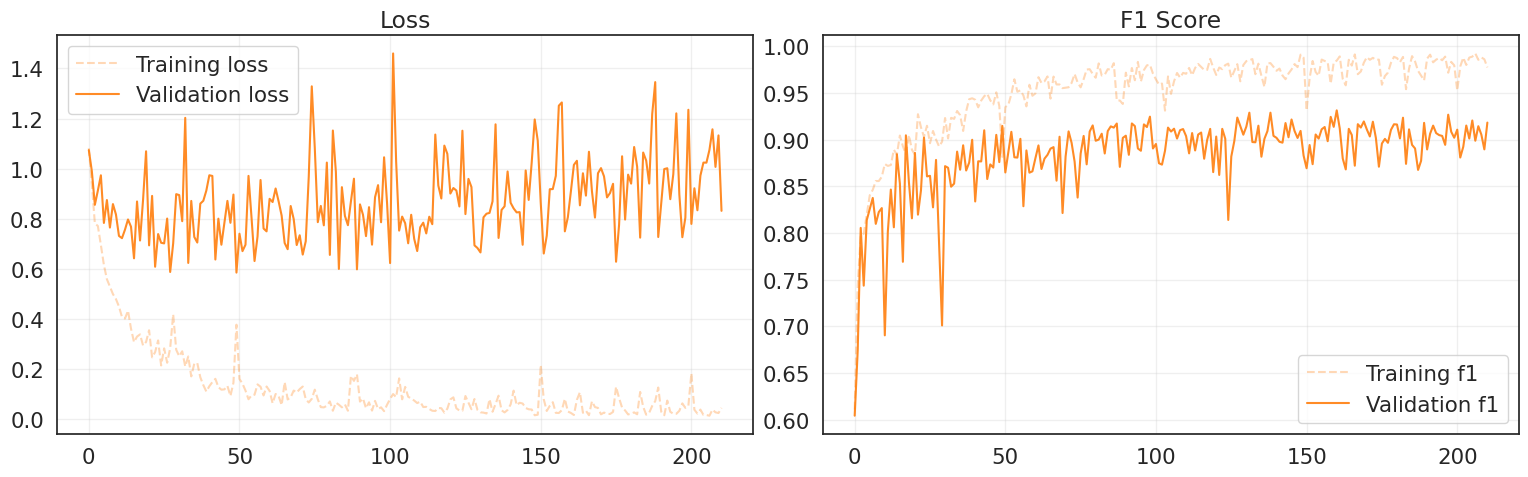

In [ ]:
# @title Plot History
# Create a figure with two side-by-side subplots (two columns)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

# Plot of training and validation loss on the first axis
ax1.plot(training_history['train_loss'], label='Training loss', alpha=0.3, color='#ff7f0e', linestyle='--')
ax1.plot(training_history['val_loss'], label='Validation loss', alpha=0.9, color='#ff7f0e')
ax1.set_title('Loss')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot of training and validation accuracy on the second axis
ax2.plot(training_history['train_f1'], label='Training f1', alpha=0.3, color='#ff7f0e', linestyle='--')
ax2.plot(training_history['val_f1'], label='Validation f1', alpha=0.9, color='#ff7f0e')
ax2.set_title('F1 Score')
ax2.legend()
ax2.grid(alpha=0.3)

# Adjust the layout and display the plot
plt.tight_layout()
plt.subplots_adjust(right=0.85)
plt.show()

Accuracy over the validation set: 0.9344
Precision over the validation set: 0.9332
Recall over the validation set: 0.9344
F1 score over the validation set: 0.9315


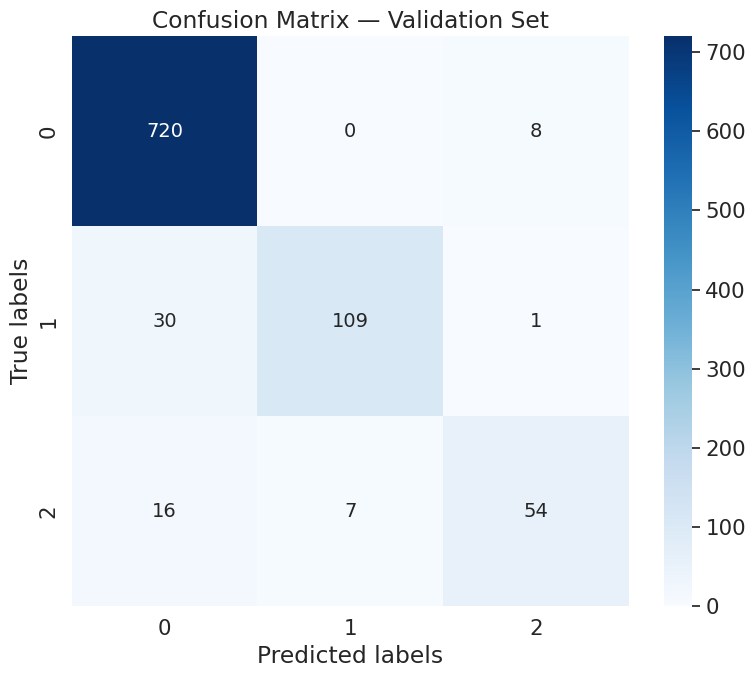

In [ ]:
# @title Plot Confusion Matrix
# Collect predictions and ground truth labels
val_preds, val_targets = [], []
with torch.no_grad():  # Disable gradient computation for inference
    for xb, x_static_batch, yb in val_loader:
        xb = xb.to(device)
        x_static_batch = x_static_batch.to(device)

        # Forward pass: get model predictions
        logits = rnn_model(xb, x_static_batch)
        preds = logits.argmax(dim=1).cpu().numpy()

        # Store batch results
        val_preds.append(preds)
        val_targets.append(yb.numpy())

# Combine all batches into single arrays
val_preds = np.concatenate(val_preds)
val_targets = np.concatenate(val_targets)

# Calculate overall validation metrics
val_acc = accuracy_score(val_targets, val_preds)
val_prec = precision_score(val_targets, val_preds, average='weighted', zero_division=0)
val_rec = recall_score(val_targets, val_preds, average='weighted', zero_division=0)
val_f1 = f1_score(val_targets, val_preds, average='weighted', zero_division=0)
print(f"Accuracy over the validation set: {val_acc:.4f}")
print(f"Precision over the validation set: {val_prec:.4f}")
print(f"Recall over the validation set: {val_rec:.4f}")
print(f"F1 score over the validation set: {val_f1:.4f}")

# Generate confusion matrix for detailed error analysis
cm = confusion_matrix(val_targets, val_preds)

# Create numeric labels for heatmap annotation
labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Visualise confusion matrix
plt.figure(figsize=(8, 7))
sns.heatmap(cm, annot=labels, fmt='',
            cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix — Validation Set')
plt.tight_layout()
plt.show()

**CROSS VALIDATION AND STUFF**
REMARK: SET A GROUND TRUTH AND START FROM THERE

In [ ]:
# Cross-validation
K = 5                    # Number of splits (5 and 10 are considered good values)
N_VAL_USERS = 135          # Number of users for validation split

# Training
EPOCHS = 500             # Maximum epochs (increase to improve performance)
PATIENCE = 50            # Early stopping patience (increase to improve performance)
VERBOSE = 10             # Print frequency

# Optimisation
LEARNING_RATE = 1e-3     # Learning rate
BATCH_SIZE = 32         # Batch size
WINDOW_SIZE = 80       # Input window size
STRIDE = 20            # Input stride

# Architecture
HIDDEN_LAYERS = 2        # Hidden layers
HIDDEN_SIZE = 64        # Neurons per layer
RNN_TYPE = 'LSTM'         # Type of RNN architecture
BIDIRECTIONAL = True    # Bidirectional RNN

# Regularisation
DROPOUT_RATE = 0.2       # Dropout probability
L1_LAMBDA = 0           # L1 penalty
L2_LAMBDA = 1e-4            # L2 penalty

# Training utilities
criterion = nn.CrossEntropyLoss()

In [ ]:
# @title
def k_shuffle_split_cross_validation_round_rnn(df, epochs, criterion, device,
                            k, n_val_users, batch_size, hidden_layers, hidden_size, learning_rate, dropout_rate,
                            window_size, stride, rnn_type, bidirectional,
                            l1_lambda, l2_lambda, patience, evaluation_metric="val_f1", mode='max',
                            restore_best_weights=True, writer=None, verbose=10, seed=42, experiment_name=""):
    """
    Perform K-fold shuffle split cross-validation with user-based splitting for time series data.

    Args:
        df: DataFrame with columns ['sample_index', 'label', 'pain_survey_X', 'n_X', 'joint_XX']
        epochs: Number of training epochs
        criterion: Loss function
        device: torch.device for computation
        k: Number of cross-validation splits
        n_val_users: Number of users for validation set
        batch_size: Batch size for training
        hidden_layers: Number of recurrent layers
        hidden_size: Hidden state dimensionality
        learning_rate: Learning rate for optimizer
        dropout_rate: Dropout rate
        window_size: Length of sliding windows
        stride: Step size for sliding windows
        rnn_type: Type of RNN ('RNN', 'LSTM', 'GRU')
        bidirectional: Whether to use bidirectional RNN
        l1_lambda: L1 regularization coefficient (if used)
        l2_lambda: L2 regularization coefficient (weight_decay)
        patience: Early stopping patience
        evaluation_metric: Metric to monitor for early stopping
        mode: 'max' or 'min' for evaluation metric
        restore_best_weights: Whether to restore best weights after training
        writer: TensorBoard writer
        verbose: Verbosity level
        seed: Random seed
        experiment_name: Name for experiment logging

    Returns:
        fold_losses: Dict with validation losses for each split
        fold_metrics: Dict with validation F1 scores for each split
        best_scores: Dict with best F1 score for each split plus mean and std
    """

    # Initialise containers for results across all splits
    fold_losses = {}
    fold_metrics = {}
    best_scores = {}

    label_col = 'label'
    user_id_col = 'sample_index'

    # Get number of classes from the global df 'label' column
    label_mapping = {
        'no_pain': 0,
        'low_pain': 1,
        'high_pain': 2,
    }
    num_classes = len(label_mapping)

    # Store initial weights to reset model for each split
    # Model is created inside the loop to ensure fresh state for each split
    initial_state = None

    # Iterate through K random splits
    for split_idx in range(k):

        if verbose > 0:
            print(f"Split {split_idx+1}/{k}")

        # Get unique user IDs and shuffle them with split-specific seed
        unique_users = df[user_id_col].unique()
        random.seed(seed + split_idx) # Use seed for reproducibility across splits
        random.shuffle(unique_users)

        # Calculate the number of users for the training set
        n_train_users = len(unique_users) - n_val_users

        # Split the shuffled user IDs into training, validation, and test sets
        train_users = unique_users[:n_train_users]
        val_users = unique_users[n_train_users:n_train_users + n_val_users]

        # Create deep copies for each split to avoid modifying the original df or other splits
        df_train_split = df[df[user_id_col].isin(train_users)].copy()
        df_val_split = df[df[user_id_col].isin(val_users)].copy()

        # Apply label mapping to convert string labels to integers for the current split
        df_train_split['label'] = df_train_split['label'].map(label_mapping)
        df_val_split['label'] = df_val_split['label'].map(label_mapping)

        if verbose > 0:
            print(f"  Training set shape: {df_train_split.shape}")
            print(f"  Validation set shape: {df_val_split.shape}")

        # Dynamically identify feature columns for scaling and sequence building
        all_feature_cols = [col for col in df_train_split.columns if col not in [user_id_col, 'time', label_col]]
        feature_cols_for_sequence = [col for col in df_train_split.columns if col.startswith('joint_')]

        # Normalise features using training set statistics for *this split*
        # Calculate min/max only from the training split of the current fold
        mins = df_train_split[all_feature_cols].min()
        maxs = df_train_split[all_feature_cols].max()

        # Apply normalization and ensure float32 for all numerical feature columns in all splits
        for col in all_feature_cols:
            # Handle potential division by zero if max equals min (constant column)
            divisor = (maxs[col] - mins[col])
            if divisor == 0: # If column is constant, assign 0 (or keep original value, depending on desired behavior)
                df_train_split[col] = 0.0 # Or keep df_train_split[col] as is if it's already a constant
                df_val_split[col] = 0.0
            else:
                df_train_split[col] = ((df_train_split[col] - mins[col]) / divisor).astype(np.float32)
                df_val_split[col] = ((df_val_split[col] - mins[col]) / divisor).astype(np.float32)

        # Build sequences using the modified build_sequences functions
        X_train, y_train_split, seq_ids_train_split = build_sequences(df_train_split, window=window_size, stride=stride, feature_columns_to_extract=feature_cols_for_sequence)
        X_val, y_val_split, seq_ids_val_split = build_sequences(df_val_split, window=window_size, stride=stride, feature_columns_to_extract=feature_cols_for_sequence)

        # Also get static features for this split
        static_cols = ['n_legs', 'n_hands', 'n_eyes']
        static_train_df_split = df_train_split.groupby('sample_index')[static_cols].first().astype(np.float32)
        static_val_df_split   = df_val_split.groupby('sample_index')[static_cols].first().astype(np.float32)

        X_train_static = build_static_array_from_seq_ids(seq_ids_train_split, static_train_df_split)
        X_val_static   = build_static_array_from_seq_ids(seq_ids_val_split, static_val_df_split)


        if verbose > 0:
            print(f"  Training sequences shape: {X_train.shape}")
            print(f"  Validation sequences shape: {X_val.shape}")
            # Note: There is no X_test processing within this CV function currently

        # Create PyTorch datasets
        train_ds = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(X_train_static), torch.from_numpy(y_train_split)) # Using y_train_split
        val_ds   = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(X_val_static), torch.from_numpy(y_val_split)) # Using y_val_split

        # Create data loaders
        train_loader = make_loader(train_ds, batch_size=batch_size, shuffle=True, drop_last=False)
        val_loader   = make_loader(val_ds, batch_size=batch_size, shuffle=False, drop_last=False)

        # The input size for the RNN is the number of features in the sequences
        rnn_input_size = len(feature_cols_for_sequence)

        # Initialise model inside the loop to ensure fresh state for each split
        model = RecurrentClassifier(
            input_size=rnn_input_size,
            hidden_size=hidden_size,
            num_layers=hidden_layers,
            num_classes=num_classes,
            dropout_rate=dropout_rate,
            bidirectional=bidirectional,
            rnn_type=rnn_type,
            static_size=X_train_static.shape[1]
        ).to(device)

        # Calculate class weights for this split's training data
        split_class_labels = np.unique(y_train_split)
        split_class_weights_np = compute_class_weight(
            class_weight='balanced',
            classes=split_class_labels,
            y=y_train_split
        )
        split_class_weights_tensor = torch.tensor(split_class_weights_np, dtype=torch.float32).to(device)

        # Define criterion for this split with calculated weights
        split_criterion = nn.CrossEntropyLoss(weight=split_class_weights_tensor, label_smoothing=LABEL_SMOOTHING)

        # Define optimizer with L2 regularization
        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=l2_lambda)

        # Enable mixed precision training for GPU acceleration
        split_scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

        # Create directory for model checkpoints
        os.makedirs(f"models/{experiment_name}", exist_ok=True)

        # Train model on current split
        model, training_history = fit(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            epochs=epochs,
            criterion=split_criterion, # Pass the split-specific criterion
            optimizer=optimizer,
            scaler=split_scaler,
            device=device,
            writer=writer,
            patience=patience,
            verbose=verbose,
            l1_lambda=l1_lambda,
            evaluation_metric=evaluation_metric,
            mode=mode,
            restore_best_weights=restore_best_weights,
            experiment_name=experiment_name+"/split_"+str(split_idx)
        )

        # Store results for this split
        # Store the entire history for plotting purposes
        fold_losses[f"split_{split_idx}"] = training_history['val_loss']
        fold_metrics[f"split_{split_idx}"] = training_history['val_f1']

        # Also store the best single F1 score for mean/std calculation
        best_val_f1_in_split = max(training_history['val_f1'])
        # The best_val_loss_in_split is derived from the F1, we just need to ensure 'best_scores' gets the float
        best_scores[f"split_{split_idx}"] = best_val_f1_in_split

    # Compute mean and standard deviation of best scores across splits
    best_scores["mean"] = np.mean([best_scores[k] for k in best_scores.keys() if k.startswith("split_")])
    best_scores["std"] = np.std([best_scores[k] for k in best_scores.keys() if k.startswith("split_")])

    if verbose > 0:
        print(f"Best score: {best_scores['mean']:.4f}\u00b1{best_scores['std']:.4f}")

    return fold_losses, fold_metrics, best_scores

In [ ]:

%%time
# Execute K-fold cross-validation with baseline configuration
losses, metrics, best_scores = k_shuffle_split_cross_validation_round_rnn(
    df=df,
    epochs=EPOCHS,
    criterion=criterion,
    device=device,
    k=K,
    batch_size=BATCH_SIZE,
    hidden_layers=HIDDEN_LAYERS,
    hidden_size=HIDDEN_SIZE,
    learning_rate=LEARNING_RATE,
    dropout_rate=DROPOUT_RATE,
    l1_lambda=L1_LAMBDA,
    l2_lambda=L2_LAMBDA,
    verbose=VERBOSE,
    patience=PATIENCE,
    seed=SEED,
    experiment_name="gru_baseline",
    n_val_users=N_VAL_USERS,
    window_size=WINDOW_SIZE,
    stride=STRIDE,
    rnn_type=RNN_TYPE,
    bidirectional=BIDIRECTIONAL
)

Split 1/5
  Training set shape: (84160, 40)
  Validation set shape: (21600, 40)
  Training sequences shape: (2630, 80, 30)
  Validation sequences shape: (675, 80, 30)
Training 500 epochs...
Epoch   1/500 | Train: Loss=0.7238, F1 Score=0.6676 | Val: Loss=0.6748, F1 Score=0.6704
Epoch  10/500 | Train: Loss=0.3681, F1 Score=0.8526 | Val: Loss=0.5577, F1 Score=0.8079
Epoch  20/500 | Train: Loss=0.2805, F1 Score=0.9007 | Val: Loss=0.5143, F1 Score=0.8308
Epoch  30/500 | Train: Loss=0.1544, F1 Score=0.9449 | Val: Loss=0.4888, F1 Score=0.8434
Epoch  40/500 | Train: Loss=0.2483, F1 Score=0.9176 | Val: Loss=0.4847, F1 Score=0.8359
Epoch  50/500 | Train: Loss=0.1825, F1 Score=0.9370 | Val: Loss=0.4709, F1 Score=0.8371
Epoch  60/500 | Train: Loss=0.0932, F1 Score=0.9689 | Val: Loss=0.4295, F1 Score=0.8871
Epoch  70/500 | Train: Loss=0.0848, F1 Score=0.9710 | Val: Loss=0.5244, F1 Score=0.8695
Epoch  80/500 | Train: Loss=0.0652, F1 Score=0.9767 | Val: Loss=0.4221, F1 Score=0.9033
Epoch  90/500 | Tr

In [ ]:
import shutil

# Assuming 'best_scores' and 'experiment_name' (from k-fold) are available
# 'best_scores' is a dictionary containing F1 scores for each split and their mean/std.
# 'experiment_name' for k-fold was 'gru_baseline'.

# Find the split with the highest F1 score
overall_best_f1_kfold = -1.0
best_split_index_kfold = -1

for i in range(K): # K is the number of splits from the cross-validation setup
    current_split_f1 = best_scores[f'split_{i}']
    if current_split_f1 > overall_best_f1_kfold:
        overall_best_f1_kfold = current_split_f1
        best_split_index_kfold = i

# Define the source path for the best model from the best split
source_model_filename = f"gru_baseline/split_{best_split_index_kfold}_model.pt"
source_model_path = os.path.join("models", source_model_filename)

# Define the destination path for the overall best model
destination_model_filename = f"best_kfold_model_f1_{overall_best_f1_kfold:.4f}.pt"
destination_model_path = os.path.join("models", destination_model_filename)

# Ensure the source model file exists before copying
if os.path.exists(source_model_path):
    # Copy the best model from the best split to a new, descriptive filename
    shutil.copyfile(source_model_path, destination_model_path)
    print(f"Overall best K-fold model (F1: {overall_best_f1_kfold:.4f} from split {best_split_index_kfold}) saved to: {destination_model_path}")
else:
    print(f"Error: Best model for split {best_split_index_kfold} not found at {source_model_path}")
    print("Please ensure the K-fold cross-validation training was executed successfully.")

# Update the best_performance variable for consistency if desired
best_performance = overall_best_f1_kfold


Overall best K-fold model (F1: 0.9324 from split 0) saved to: models/best_kfold_model_f1_0.9324.pt


In [ ]:
# Create an inverse mapping from numeric labels back to string labels
inverse_label_mapping = {
    0: 'no_pain',
    1: 'low_pain',
    2: 'high_pain'
}

# The `test_ds` should already be defined correctly in n4g715TtSytf:
# test_ds = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(X_test_static).float())
# We don't redefine test_ds here.

# Create DataLoader for the test set (using the already defined test_ds)
test_loader = make_loader(test_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

# --- Load the best K-fold model ---
# The path to the best K-fold model was saved in the previous cell
best_kfold_model_path = destination_model_path # From the previous cell 9UQK2Wls-7BZ

# Instantiate a new model with the architecture used for the best K-fold run
# Parameters should match the best performing config from k-fold, which were set globally for the k-fold run
# (HIDDEN_SIZE, HIDDEN_LAYERS, RNN_TYPE='GRU', BIDIRECTIONAL=True)
model_for_prediction = RecurrentClassifier(
    input_size=len(actual_joint_columns_global), # Use the dynamically determined number of joint features
    hidden_size=HIDDEN_SIZE,
    num_layers=HIDDEN_LAYERS,
    num_classes=num_classes, # Use the globally available num_classes
    dropout_rate=DROPOUT_RATE,
    bidirectional=BIDIRECTIONAL,
    rnn_type=RNN_TYPE, # Use the RNN_TYPE (GRU) that performed best in K-fold
    static_size=X_test_static.shape[1] # Pass static_size here
).to(device)

# Load the state dictionary of the best K-fold model
model_for_prediction.load_state_dict(torch.load(best_kfold_model_path, map_location=device))
model_for_prediction.eval() # Set the loaded model to evaluation mode

all_test_predictions = []
# The seq_ids_test array generated by build_sequences already maps sequence predictions to sample_index.
# We will use this directly for grouping after predictions.

# Perform inference on the test set using the loaded best K-fold model
with torch.no_grad():
    for inputs_batch, static_inputs_batch in test_loader: # Unpack inputs and static_inputs
        inputs_batch = inputs_batch.to(device)
        static_inputs_batch = static_inputs_batch.to(device) # Move static inputs to device

        # Get model outputs
        outputs = model_for_prediction(inputs_batch, static_inputs_batch) # Pass both inputs

        # Get predicted class (the one with the highest probability)
        predictions = outputs.argmax(dim=1).cpu().numpy()

        all_test_predictions.extend(predictions)

# Combine seq_ids_test and predictions into a DataFrame
predictions_df = pd.DataFrame({
    'sample_index': seq_ids_test, # Use the global seq_ids_test array
    'predicted_label_numeric': all_test_predictions
})

# Group by sample_index and determine the final prediction (e.g., by taking the mode)
# Using pandas Series.mode() which is typically more robust for Series.
# Add a check for empty group to avoid IndexError.
final_predictions_grouped = predictions_df.groupby('sample_index')['predicted_label_numeric'].apply(
    lambda x: x.mode()[0] if not x.empty else np.nan # If a group is empty, assign NaN
)
final_predictions_df = final_predictions_grouped.reset_index()
final_predictions_df.columns = ['sample_index', 'predicted_label_numeric']

# Map numeric predictions back to string labels
final_predictions_df['predicted_label'] = final_predictions_df['predicted_label_numeric'].map(inverse_label_mapping)

# Define the output filename
output_filename = 'pirate_pain_predictions.csv'

# Save the DataFrame to a CSV file
final_predictions_df[['sample_index', 'predicted_label']].to_csv(output_filename, index=False)

print(f"Predictions saved to {output_filename}")
display(final_predictions_df.head())

# The file is already saved to Google Drive because the current working directory
# is set to '/gdrive/My Drive/Challenge1-Datasets'. No need to copy it again.
print(f"File '{output_filename}' is already saved to Google Drive at '{current_dir}/{output_filename}'")

NameError: name 'make_loader' is not defined

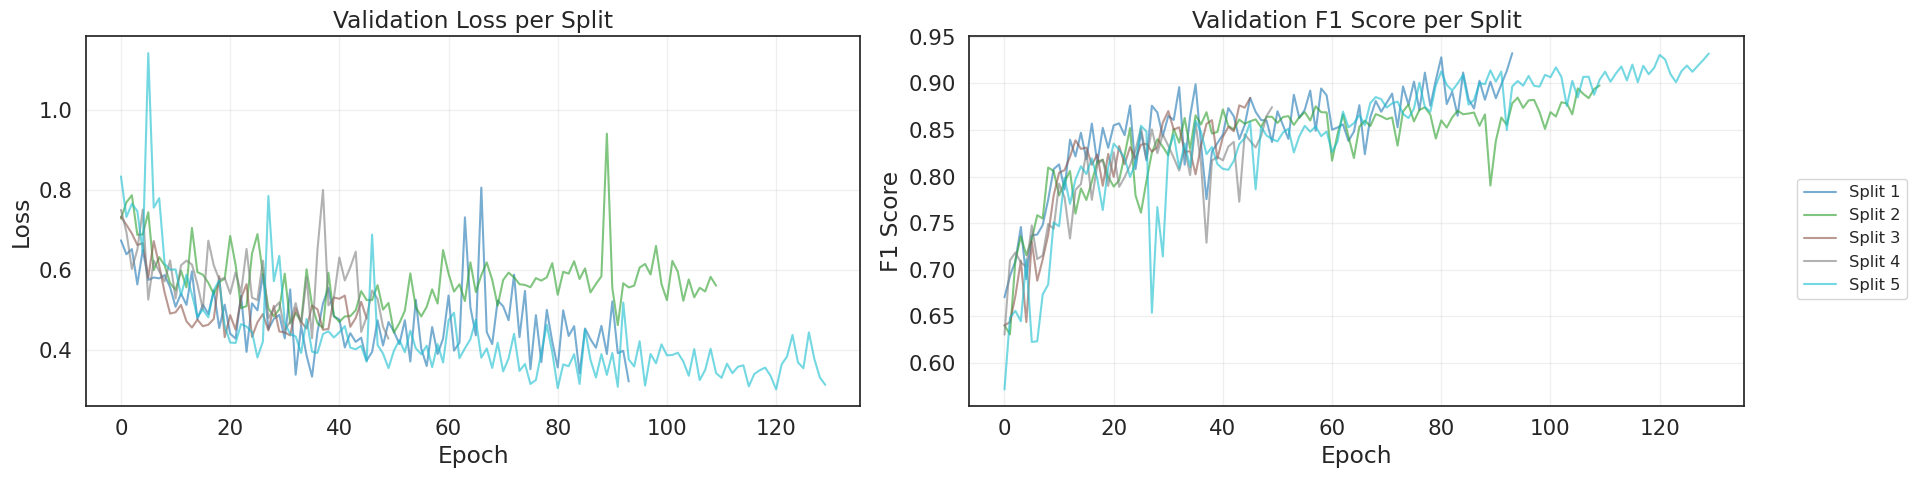

In [ ]:
# @title Plot Hitory
# Create figure with two subplots sharing x axis
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 5), sharex=True)

# Color palette for K splits
colors = plt.cm.get_cmap('tab10', K)

# Plot validation loss for each split
for split in range(K):
    axes[0].plot(losses[f'split_{split}'][:-PATIENCE], label=f'Split {split+1}',
                 color=colors(split), alpha=0.6)
axes[0].set_title('Validation Loss per Split')
axes[0].set_ylabel('Loss')
axes[0].set_xlabel('Epoch')
axes[0].grid(alpha=0.3)

# Plot validation F1 score for each split
for split in range(K):
    axes[1].plot(metrics[f'split_{split}'][:-PATIENCE], label=f'Split {split+1}',
                 color=colors(split), alpha=0.6)
axes[1].set_title('Validation F1 Score per Split')
axes[1].set_ylabel('F1 Score')
axes[1].set_xlabel('Epoch')
axes[1].grid(alpha=0.3)

# Add shared legend on the right
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(right=0.975)
plt.show()

In [ ]:
# @title Plot Confusion Matrix for Best K-fold Validation Set
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

# Re-create the validation data for the best performing split
label_col = 'label'
user_id_col = 'sample_index'
label_mapping = {
    'no_pain': 0,
    'low_pain': 1,
    'high_pain': 2,
}
# num_classes should be available globally, but we can re-derive it safely
num_classes_derived = len(label_mapping)

# Re-run the user splitting logic for the best split
unique_users = df[user_id_col].unique()
random.seed(SEED + best_split_index_kfold) # Use the same seed as that split
random.shuffle(unique_users)

n_train_users_best_split = len(unique_users) - N_VAL_USERS
train_users_best_split = unique_users[:n_train_users_best_split]
val_users_best_split = unique_users[n_train_users_best_split:n_train_users_best_split + N_VAL_USERS]

df_train_split_best = df[df[user_id_col].isin(train_users_best_split)].copy()
df_val_split_best = df[df[user_id_col].isin(val_users_best_split)].copy()

# Apply label mapping
df_train_split_best['label'] = df_train_split_best['label'].map(label_mapping)
df_val_split_best['label'] = df_val_split_best['label'].map(label_mapping)

# Dynamically identify feature columns for scaling and sequence building for this split
all_feature_cols_best_split = [col for col in df_train_split_best.columns if col not in [user_id_col, 'time', label_col]]
feature_cols_for_sequence_best_split = [col for col in df_train_split_best.columns if col.startswith('joint_')]

# Normalize features using training set statistics for this specific split
mins_best_split = df_train_split_best[all_feature_cols_best_split].min()
maxs_best_split = df_train_split_best[all_feature_cols_best_split].max()

for col in all_feature_cols_best_split:
    divisor = (maxs_best_split[col] - mins_best_split[col])
    if divisor == 0: # If column is constant, assign 0.0 for consistent typing
        df_train_split_best[col] = 0.0
        df_val_split_best[col] = 0.0
    else:
        df_train_split_best[col] = ((df_train_split_best[col] - mins_best_split[col]) / divisor).astype(np.float32)
        df_val_split_best[col] = ((df_val_split_best[col] - mins_best_split[col]) / divisor).astype(np.float32)

# Build sequences for validation set of best split
X_val_best_split, y_val_best_split, seq_ids_val_best_split = build_sequences(
    df_val_split_best, WINDOW_SIZE, STRIDE, feature_columns_to_extract=feature_cols_for_sequence_best_split
)

# Get static features for this split
static_cols = ['n_legs', 'n_hands', 'n_eyes']
static_val_df_best = df_val_split_best.groupby('sample_index')[static_cols].first().astype(np.float32)
X_val_static_best_split = build_static_array_from_seq_ids(seq_ids_val_best_split, static_val_df_best)

# Create DataLoader for the validation set of the best split
val_ds_best_split = TensorDataset(torch.from_numpy(X_val_best_split), torch.from_numpy(X_val_static_best_split), torch.from_numpy(y_val_best_split))
val_loader_best_split = make_loader(val_ds_best_split, BATCH_SIZE, shuffle=False, drop_last=False)

# Load the best K-fold model (destination_model_path should be available from earlier execution)
model_for_conf_matrix = RecurrentClassifier(
    input_size=len(feature_cols_for_sequence_best_split), # Use the dynamically determined number of joint features
    hidden_size=HIDDEN_SIZE,
    num_layers=HIDDEN_LAYERS,
    num_classes=num_classes_derived,
    dropout_rate=DROPOUT_RATE,
    bidirectional=BIDIRECTIONAL,
    rnn_type=RNN_TYPE,
    static_size=X_val_static_best_split.shape[1]
).to(device)

model_for_conf_matrix.load_state_dict(torch.load(destination_model_path, map_location=device))
model_for_conf_matrix.eval()

# Collect predictions and ground truth labels for the best split's validation set
val_preds_best_split, val_targets_best_split = [], []
with torch.no_grad():
    for xb, x_static_batch, yb in val_loader_best_split:
        xb = xb.to(device)
        x_static_batch = x_static_batch.to(device)
        logits = model_for_conf_matrix(xb, x_static_batch)
        preds = logits.argmax(dim=1).cpu().numpy()
        val_preds_best_split.append(preds)
        val_targets_best_split.append(yb.numpy())

val_preds_best_split = np.concatenate(val_preds_best_split)
val_targets_best_split = np.concatenate(val_targets_best_split)

# Calculate overall validation metrics for this split
val_acc = accuracy_score(val_targets_best_split, val_preds_best_split)
val_prec = precision_score(val_targets_best_split, val_preds_best_split, average='weighted', zero_division=0)
val_rec = recall_score(val_targets_best_split, val_preds_best_split, average='weighted', zero_division=0)
val_f1 = f1_score(val_targets_best_split, val_preds_best_split, average='weighted', zero_division=0)
print(f"Metrics for Validation Set of Best K-fold Split (Fold {best_split_index_kfold+1}):")
print(f"Accuracy: {val_acc:.4f}")
print(f"Precision: {val_prec:.4f}")
print(f"Recall: {val_rec:.4f}")
print(f"F1 score: {val_f1:.4f}")

# Generate confusion matrix
cm_best_split = confusion_matrix(val_targets_best_split, val_preds_best_split)

# Map numeric labels back to string labels for better readability in the plot
inverse_label_mapping = {0: 'no_pain', 1: 'low_pain', 2: 'high_pain'}
class_labels = [inverse_label_mapping[i] for i in sorted(inverse_label_mapping.keys())]

# Visualise confusion matrix
plt.figure(figsize=(8, 7))
sns.heatmap(cm_best_split, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels
           )
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title(f'Confusion Matrix — Validation Set (Best K-fold Split Fold {best_split_index_kfold+1})')
plt.tight_layout()
plt.show()

NameError: name 'best_split_index_kfold' is not defined

**NOW STARTS ACTUAL HYPERPARAMS TUNING**

In [ ]:
def grid_search_cv_rnn(df, param_grid, fixed_params, cv_params, verbose=True):
    """
    Execute grid search with K-shuffle-split cross-validation for RNN models on time series data.

    Args:
        df: DataFrame with columns ['user_id', 'activity', 'x_axis', 'y_axis', 'z_axis', 'id']
        param_grid: Dict of parameters to test, e.g. {'batch_size': [16, 32], 'rnn_type': ['LSTM', 'GRU']}
        fixed_params: Dict of fixed hyperparameters (hidden_size, learning_rate, window_size, stride, etc.)
        cv_params: Dict of CV settings (epochs, k, patience, criterion, scaler, device, etc.)
        verbose: Print progress for each configuration

    Returns:
        results: Dict with scores for each configuration
        best_config: Dict with best hyperparameter combination
        best_score: Best mean F1 score achieved
    """
    # Generate all parameter combinations
    param_names = list(param_grid.keys())
    param_values = list(param_grid.values())
    combinations = list(product(*param_values))

    results = {}
    best_score = -np.inf
    best_config = None

    total = len(combinations)

    for idx, combo in enumerate(combinations, 1):
        # Create current configuration dict
        current_config = dict(zip(param_names, combo))
        config_str = "_".join([f"{k}_{v}" for k, v in current_config.items()])

        if verbose:
            print(f"\nConfiguration {idx}/{total}:")
            for param, value in current_config.items():
                print(f"  {param}: {value}")

        # Merge current config with fixed parameters
        run_params = {**fixed_params, **current_config}

        # Execute cross-validation
        _, _, fold_scores = k_shuffle_split_cross_validation_round_rnn(
            df=df,
            experiment_name=config_str,
            **run_params,
            **cv_params
        )

        # Store results
        results[config_str] = fold_scores

        # Track best configuration
        if fold_scores["mean"] > best_score:
            best_score = fold_scores["mean"]
            best_config = current_config.copy()
            if verbose:
                print("  NEW BEST SCORE!")

        if verbose:
            print(f"  F1 Score: {fold_scores['mean']:.4f}±{fold_scores['std']:.4f}")

    return results, best_config, best_score


def plot_top_configurations_rnn(results, k_splits, top_n=5, figsize=(14, 7)):
    """
    Visualise top N RNN configurations with boxplots of F1 scores across CV splits.

    Args:
        results: Dict of results from grid_search_cv_rnn
        k_splits: Number of CV splits used
        top_n: Number of top configurations to display
        figsize: Figure size tuple
    """
    # Sort by mean score
    config_scores = {name: data['mean'] for name, data in results.items()}
    sorted_configs = sorted(config_scores.items(), key=lambda x: x[1], reverse=True)

    # Select top N
    top_configs = sorted_configs[:min(top_n, len(sorted_configs))]

    # Prepare boxplot data
    boxplot_data = []
    labels = []

    # Define a dictionary for replacements, ordered to handle prefixes correctly
    replacements = {
        'batch_size_': 'BS=',
        'learning_rate_': '\nLR=',
        'hidden_layers_': '\nHL=',
        'hidden_size_': '\nHS=',
        'dropout_rate_': '\nDR=',
        'window_size_': '\nWS=',
        'stride_': '\nSTR=',
        'rnn_type_': '\nRNN=',
        'bidirectional_': '\nBIDIR=',
        'l1_lambda_': '\nL1=',
        'l2_lambda_': '\nL2='
    }

    # Replacements for separators
    separator_replacements = {
        '_learning_rate_': '\nLR=',
        '_hidden_layers_': '\nHL=',
        '_hidden_size_': '\nHS=',
        '_dropout_rate_': '\nDR=',
        '_window_size_': '\nWS=',
        '_stride_': '\nSTR=',
        '_rnn_type_': '\nRNN=',
        '_bidirectional_': '\nBIDIR=',
        '_l1_lambda_': '\nL1=',
        '_l2_lambda_': '\nL2=',
        '_': ''
    }

    for config_name, mean_score in top_configs:
        # Extract best score from each split (auto-detect number of splits)
        split_scores = []
        for i in range(k_splits):
            if f'split_{i}' in results[config_name]:
                split_scores.append(results[config_name][f'split_{i}'])
        boxplot_data.append(split_scores)

        # Verify we have the expected number of splits
        if len(split_scores) != k_splits:
            print(f"Warning: Config {config_name} has {len(split_scores)} splits, expected {k_splits}")

        # Create readable label using the replacements dictionary
        readable_label = config_name
        for old, new in replacements.items():
            readable_label = readable_label.replace(old, new)

        # Apply separator replacements
        for old, new in separator_replacements.items():
             readable_label = readable_label.replace(old, new)

        labels.append(f"{readable_label}\n(μ={mean_score:.3f})")

    # Create plot
    fig, ax = plt.subplots(figsize=figsize)
    bp = ax.boxplot(boxplot_data, labels=labels, patch_artist=True,
                    showmeans=True, meanline=True)

    # Styling
    for patch in bp['boxes']:
        patch.set_facecolor('lightblue')
        patch.set_alpha(0.7)

    # Highlight best configuration
    ax.get_xticklabels()[0].set_fontweight('bold')

    ax.set_ylabel('F1 Score')
    ax.set_xlabel('Configuration')
    ax.set_title(f'Top {len(top_configs)} RNN Configurations - F1 Score Distribution Across {k_splits} Splits')
    ax.grid(alpha=0.3, axis='y')

    plt.xticks(rotation=0, ha='center')
    plt.tight_layout()
    plt.show()

In [ ]:
%%time
# Define parameters to search
param_grid = {
    'window_size': [50, 100, 200, 400],
    'stride': [25, 50],
}

# Fixed hyperparameters (not being tuned)
fixed_params = {
    'batch_size': BATCH_SIZE,
    'learning_rate': LEARNING_RATE,
    'hidden_layers': HIDDEN_LAYERS,
    'hidden_size': HIDDEN_SIZE,
    'dropout_rate': DROPOUT_RATE,
    'l1_lambda': L1_LAMBDA,
    'l2_lambda': L2_LAMBDA,
    'rnn_type': RNN_TYPE,
    'bidirectional': BIDIRECTIONAL
}

# Cross-validation settings
cv_params = {
    'epochs': EPOCHS,
    'criterion': criterion,
    'device': device,
    'k': K,
    'n_val_users': N_VAL_USERS,
    'n_test_users': N_TEST_USERS,
    'patience': PATIENCE,
    'verbose': 0,
    'seed': SEED
}

# Execute search
results, best_config, best_score = grid_search_cv_rnn(
    df=df,
    param_grid=param_grid,
    fixed_params=fixed_params,
    cv_params=cv_params
)

In [ ]:
# Visualise results
plot_top_configurations_rnn(results, k_splits=K, top_n=5)

In [ ]:
# %%time
# --- 1. Combine fixed and best hyperparameters ---
# 'fixed_params' and 'best_config' are loaded from the grid search cell
final_best_params = {**fixed_params, **best_config}

# Generate config string (from grid params only) to find saved model files
best_config_str = "_".join([f"{k}_{v}" for k, v in best_config.items()])

# Initialise lists for metrics
test_accuracies = []
test_precisions = []
test_recall_scores = []
test_f1_scores = []
all_test_targets = [] # For aggregated confusion matrix
all_test_preds = []   # For aggregated confusion matrix

label_mapping = {
    'Walking': 0, 'Jogging': 1, 'Upstairs': 2,
    'Downstairs': 3, 'Sitting': 4, 'Standing': 5
}
scale_columns = ['x_axis', 'y_axis', 'z_axis']

# --- 2. Begin evaluation loop across the K splits ---
# K, SEED, N_VAL_USERS, N_TEST_USERS are defined globally
for split in range(K):
    print(f"Evaluating Split {split+1}/{K} using best config: {best_config_str}")

    # --- 3. Regenerate the exact data split for this fold ---
    # This logic must be identical to k_shuffle_split_cross_validation_round_rnn
    unique_users = df['user_id'].unique()
    random.seed(SEED + split) # Use the same CV seed
    random.shuffle(unique_users)

    n_train_users = len(unique_users) - N_VAL_USERS - N_TEST_USERS
    train_users = unique_users[:n_train_users]
    val_users = unique_users[n_train_users:n_train_users + N_VAL_USERS]
    test_users = unique_users[n_train_users + N_VAL_USERS:]

    df_train = df[df['user_id'].isin(train_users)].copy()
    df_test = df[df['user_id'].isin(test_users)].copy()

    # --- 4. Preprocess the data ---
    df_train['activity'] = df_train['activity'].map(label_mapping)
    df_test['activity'] = df_test['activity'].map(label_mapping)

    # Normalise features (fit on THIS split's training data)
    mins = df_train[scale_columns].min()
    maxs = df_train[scale_columns].max()

    for column in scale_columns:
        df_test[column] = (df_test[column] - mins[column]) / (maxs[column] - mins[column] + 1e-8)

    # --- 5. Build test sequences ---
    # Use the best window/stride from final_best_params
    X_test, y_test = build_sequences(
        df_test,
        window=final_best_params['window_size'],
        stride=final_best_params['stride']
    )

    # --- 6. Create the Test DataLoader ---
    test_ds  = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
    test_loader  = make_loader(
        test_ds,
        batch_size=final_best_params['batch_size'],
        shuffle=False,
        drop_last=False
    )

    # Handle empty test sets from user splits
    if len(test_ds) == 0:
        print(f"  WARNING: Test set for split {split+1} is empty. Skipping.")
        continue

    # --- 7. Initialise the Model ---
    # Use the best architecture parameters from the grid search
    model = RecurrentClassifier(
        input_size=X_test.shape[2], # num_features (3)
        hidden_size=final_best_params['hidden_size'],
        num_layers=final_best_params['hidden_layers'],
        num_classes=len(label_mapping), # num_classes (6)
        dropout_rate=final_best_params['dropout_rate'],
        bidirectional=final_best_params['bidirectional'],
        rnn_type=final_best_params['rnn_type']
    ).to(device)

    # --- 8. Load the model weights for this specific split and config ---
    model_path = f"models/{best_config_str}/split_{split}_model.pt"

    try:
        model.load_state_dict(torch.load(model_path, map_location=device))
    except FileNotFoundError:
        print(f"  ERROR: Model file not found at {model_path}")
        print(f"  Skipping split {split+1}.")
        continue

    model.eval() # Set model to evaluation mode

    # --- 9. Run predictions on the test set ---
    split_test_preds, split_test_targets = [], []
    with torch.no_grad(): # Disable gradient computation for inference
        for xb, yb in test_loader:
            xb = xb.to(device)
            logits = model(xb)
            preds = logits.argmax(dim=1).cpu().numpy()
            split_test_preds.append(preds)
            split_test_targets.append(yb.numpy())

    split_test_preds = np.concatenate(split_test_preds)
    split_test_targets = np.concatenate(split_test_targets)

    # --- 10. Calculate and store metrics for this split ---
    split_test_acc = accuracy_score(split_test_targets, split_test_preds)
    split_test_prec = precision_score(split_test_targets, split_test_preds, average='weighted', zero_division=0)
    split_test_rec = recall_score(split_test_targets, split_test_preds, average='weighted', zero_division=0)
    split_test_f1 = f1_score(split_test_targets, split_test_preds, average='weighted', zero_division=0)

    print(f"  Test F1 Score for Split {split+1}: {split_test_f1:.4f}")

    test_accuracies.append(split_test_acc)
    test_precisions.append(split_test_prec)
    test_recall_scores.append(split_test_rec)
    test_f1_scores.append(split_test_f1)

    all_test_targets.extend(split_test_targets)
    all_test_preds.extend(split_test_preds)


# --- 11. After the loop: Print mean metrics and plot confusion matrix ---
print("\nAverage metrics across all splits on the test set:")
print(f"Mean Accuracy: {np.mean(test_accuracies):.4f} ± {np.std(test_accuracies):.4f}")
print(f"Mean Precision: {np.mean(test_precisions):.4f} ± {np.std(test_precisions):.4f}")
print(f"Mean Recall: {np.mean(test_recall_scores):.4f} ± {np.std(test_recall_scores):.4f}")
print(f"Mean F1 score: {np.mean(test_f1_scores):.4f} ± {np.std(test_f1_scores):.4f}")


# Generate confusion matrix for the concatenated test sets
cm = confusion_matrix(all_test_targets, all_test_preds)
labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Visualise confusion matrix
plt.figure(figsize=(8, 7))
sns.heatmap(cm, annot=labels, fmt='',
            cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Aggregated Confusion Matrix — Test Sets Across Splits')
plt.tight_layout()
plt.show()

The end